In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import sys

sys.path.append("..")

In [4]:
from rdkit import Chem
import rdkit
import itertools
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.ChemicalFeatures import MolChemicalFeature
from rdkit import RDConfig
import os


random_seed = 42

In [5]:
from src.draw.mol import show_3d
from src.mol_processing.mol import get_protein_from_pdb_file, remove_water_from_rdkit_mol

receptor = get_protein_from_pdb_file("../data/receptors/2oi0.pdb")

Chem.GetSymmSSSR(receptor)

receptor.GetRingInfo().NumRings()
remove_water_from_rdkit_mol(receptor)

show_3d(receptor)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
ligand = Chem.SDMolSupplier("../data/ligands/283_model.sdf", sanitize=True, removeHs=False)[0]

ligand.UpdatePropertyCache()
Chem.GetSymmSSSR(ligand)
ligand.GetRingInfo().NumRings()

show_3d(ligand)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:
from src.draw.features import show_molecule_with_features
from src.mol_processing.features import extract_pharmacophores


ligand_features = extract_pharmacophores(ligand, "l")
print(len(ligand_features))
show_molecule_with_features(ligand, ligand_features)

15


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
from src.draw.features import show_molecule_with_features
from src.graph.interaction_graph import filter_receptor_features_close_to_ligand
from src.mol_processing.features import extract_pharmacophores


receptor_features = extract_pharmacophores(receptor, "R")
print(len(receptor_features))


1360


In [9]:
_, R_features = filter_receptor_features_close_to_ligand(ligand_features, R_features=receptor_features, max_distance=6.5)
show_molecule_with_features(receptor, R_features)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
from src.draw.features import visualize_docking_site


visualize_docking_site(receptor, ligand, ligand_features, list(R_features))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# --- Imports et Configuration ---
import os
import itertools
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
import numpy as np
import py3Dmol

# --- Chemin d'accès corrigé vers le fichier de définition des pharmacophores ---
fdef_file = os.path.join(RDConfig.RDDataDir, "BaseFeatures.fdef")
factory = AllChem.BuildFeatureFactory(fdef_file)

# --- NOUVEAU Dictionnaire de couleurs et de propriétés ---
# Note: la bibliothèque typing.Final n'est pas nécessaire pour une utilisation directe
SELECTED_FEATURES = {
    "Donor": {"abbreviation": "d", "attractors": ["a"], "color": "blue"},
    "Acceptor": {"abbreviation": "a", "attractors": ["d"], "color": "red"},
    "NegIonizable": {"abbreviation": "n", "attractors": ["p"], "color": "yellow"},
    "PosIonizable": {"abbreviation": "p", "attractors": ["n"], "color": "green"},
    "Aromatic": {"abbreviation": "ar", "attractors": ["ar"], "color": "orange"},
    "Hydrophobe": {"abbreviation": "h", "attractors": ["h"], "color": "purple"},
}
# On crée une version simplifiée pour un accès facile à la couleur
COLOR_MAP = {key: value["color"] for key, value in SELECTED_FEATURES.items()}

In [88]:
# --- Fonctions ---

from src.mol_processing.features import Feature, FeatureFamily


def select_receptor_points(
    receptor_mol: Chem.Mol,
    ligand_mol: Chem.Mol,
    receptor_id: str = "receptor",
    proximity_cutoff: float = 10.0,
    target_dist: float = 7.5,
    dist_tolerance: float = 1.0,
    max_perp_dist: float = 2.5,
    cluster_radius: float = 4.0,
) -> list[Feature] | None:
    """
    Sélectionne 4 points sur le récepteur en ignorant les features 'LumpedHydrophobe'
    et en appliquant les contraintes géométriques et de diversité.
    """
    print("1. Identification de 4 points sur le récepteur (filtrage de 'LumpedHydrophobe')...")

    # Étape 1: Extraire toutes les features
    all_features_raw = factory.GetFeaturesForMol(receptor_mol)

    # --- NOUVEAU: Filtrer les features de type 'LumpedHydrophobe' ---
    all_features = [f for f in all_features_raw if f.GetFamily() != "LumpedHydrophobe"]

    print(
        f"-> {len(all_features_raw)} features initiales trouvées. Après filtrage, {len(all_features)} points sont conservés."
    )

    # Étape 2: Pré-filtrer les points restants par proximité avec le ligand
    ligand_center = ligand_mol.GetConformer(0).GetPositions().mean(axis=0)
    ligand_center_pt = Point3D(*ligand_center)
    proximal_features = [
        f for f in all_features if f.GetPos().Distance(ligand_center_pt) <= proximity_cutoff
    ]

    print(f"-> {len(proximal_features)} points proximaux trouvés.")
    if len(proximal_features) < 4:
        print("-> ATTENTION: Moins de 4 points proximaux, impossible de former un quartet.")
        return None

    # Étape 3: Chercher le quartet géométrique et chimiquement divers
    for p1_rd, p4_rd in itertools.combinations(proximal_features, 2):
        pos1, pos4 = p1_rd.GetPos(), p4_rd.GetPos()
        dist_p1_p4 = pos1.Distance(pos4)

        if not (target_dist - dist_tolerance <= dist_p1_p4 <= target_dist + dist_tolerance):
            continue

        line_vec, line_len_sq = pos4 - pos1, (pos4 - pos1).LengthSq()
        for p2_rd in proximal_features:
            if p2_rd in [p1_rd, p4_rd]:
                continue

            pos2 = p2_rd.GetPos()
            dot_product = (pos2 - pos1).DotProduct(line_vec)

            if 0 <= dot_product <= line_len_sq:
                perp_dist = pos2.Distance(pos1 + line_vec * (dot_product / line_len_sq))

                if perp_dist <= max_perp_dist:
                    for p3_rd in proximal_features:
                        if p3_rd in [p1_rd, p2_rd, p4_rd]:
                            continue

                        if pos2.Distance(p3_rd.GetPos()) <= cluster_radius:
                            quartet_rd = [p1_rd, p2_rd, p3_rd, p4_rd]
                            families = {p.GetFamily() for p in quartet_rd}

                            if len(families) == 4:
                                print("-> Quartet géométrique avec 4 familles distinctes trouvé !")

                                selected_features = []
                                for i, rd_feature in enumerate(quartet_rd):
                                    feature_object = Feature.from_rdkit(rd_feature, receptor_id)
                                    abbreviation = feature_object.family.abbreviation.upper()
                                    feature_object.name = f"{abbreviation}{i+1}"
                                    selected_features.append(feature_object)

                                return selected_features

    print("-> ATTENTION: Aucun quartet satisfaisant toutes les contraintes n'a été trouvé.")
    return None


def select_ligand_points_for_flexibility(ligand_mol: Chem.Mol, ligand_id: str = "ligand") -> tuple[list[Feature] | None, tuple[int, int] | None]:
    """
    Analyse le ligand, retourne les 3 objets Feature avec le format de nom corrigé,
    et les ID des conformers pertinents.
    """
    print("\n2. Analyse de la flexibilité du ligand...")
    features, conformers = factory.GetFeaturesForMol(ligand_mol), ligand_mol.GetConformers()
    if len(conformers) < 2: return None, None

    # ... (logique de sélection inchangée) ...
    max_dist_diff, best_pair_indices, best_conf_indices = -1.0, None, None
    for i, j in itertools.combinations(range(len(features)), 2):
        distances = [features[i].GetPos(c.GetId()).Distance(features[j].GetPos(c.GetId())) for c in conformers]
        dist_diff = np.max(distances) - np.min(distances)
        if dist_diff > max_dist_diff:
            max_dist_diff, best_pair_indices = dist_diff, (i, j)
            conf_idx_min, conf_idx_max = int(np.argmin(distances)), int(np.argmax(distances))
            best_conf_indices = (conformers[conf_idx_min].GetId(), conformers[conf_idx_max].GetId())
    if best_pair_indices is None: return None, None
    p1_rd, p2_rd = features[best_pair_indices[0]], features[best_pair_indices[1]]
    p_aromatic_rd = next((f for i, f in enumerate(features) if f.GetFamily() == 'Aromatic' and i not in best_pair_indices), None) or \
                    next((f for i, f in enumerate(features) if i not in best_pair_indices), None)

    print("-> Points ligand pour la flexibilité identifiés.")
    selected_features = []
    for i, rd_feature in enumerate([p1_rd, p2_rd, p_aromatic_rd]):
        family = FeatureFamily.from_family_name(rd_feature.GetFamily())
        position = tuple(rd_feature.GetPos(best_conf_indices[0])); atom_ids = rd_feature.GetAtomIds()
        feature_object = Feature(family, position, atom_ids, ligand_id)
        abbreviation = feature_object.family.abbreviation.lower()
        # --- FORMAT DE NOM CORRIGÉ ---
        feature_object.name = f"{abbreviation}{i+1}"
        selected_features.append(feature_object)
    return selected_features, best_conf_indices


def visualize_receptor_with_points(receptor_mol: Chem.Mol, selected_features: list[Feature]) -> py3Dmol.view:
    """
    Crée une visualisation du récepteur, avec un zoom correct et sans lignes de distance.
    """
    if not selected_features: return None
    print("\n3. Création de la vue py3Dmol pour le récepteur...")
    view = py3Dmol.view(width=1500, height=1200)

    view.addModel(Chem.MolToPDBBlock(receptor_mol), 'pdb')
    view.setStyle({'cartoon': {'color': 'lightgray', 'opacity': 0.7}})

    for feature in selected_features:
        pos = feature.position
        view.addSphere({'center': dict(zip('xyz', pos)), 'radius': 0.8, 'color': feature.family.color})
        # --- TAILLE DE LABEL AUGMENTÉE ---
        view.addLabel(feature.name, {'position': {'x': pos[0] + 1.5, 'y': pos[1], 'z': pos[2]},
                                    'fontColor': 'black', 'fontSize': 32,
                                    'backgroundColor': 'white', 'backgroundOpacity': 0.6})

    view.setBackgroundColor('white')
    # --- ZOOM CORRIGÉ ---
    # Le zoom par défaut cadre l'ensemble de la scène (protéine + sphères)
    view.zoomTo()

    print("-> Vue récepteur prête.")
    return view


def visualize_ligand_flexibility_py3dmol(ligand_mol: Chem.Mol, selected_features: list[Feature], conf_ids: tuple) -> py3Dmol.view:
    """
    Crée une visualisation du ligand, sans lignes de distance et avec des labels plus grands.
    """
    if not selected_features or not conf_ids: return None
    print("\n4. Création de la vue py3Dmol pour le ligand...")
    view = py3Dmol.view(viewergrid=(2, 1), width=1000, height=1500, linked=True)

    conf1 = ligand_mol.GetConformer(conf_ids[0]); conf2 = ligand_mol.GetConformer(conf_ids[1])
    view.addModel(Chem.MolToPDBBlock(ligand_mol, confId=conf_ids[0]), 'pdb', viewer=(0, 0))
    view.addModel(Chem.MolToPDBBlock(ligand_mol, confId=conf_ids[1]), 'pdb', viewer=(1, 0))
    view.setStyle({'stick': {'color': 'lightgray'}}, viewer=(0, 0)); view.setStyle({'stick': {'color': 'lightgray'}}, viewer=(1, 0))

    all_positions = []
    for feature in selected_features:
        pos1 = np.mean([conf1.GetAtomPosition(i) for i in feature.atom_ids], axis=0)
        pos2 = np.mean([conf2.GetAtomPosition(i) for i in feature.atom_ids], axis=0)
        all_positions.extend([pos1, pos2])

        view.addSphere({'center': dict(zip('xyz', pos1)), 'radius': 0.8, 'color': feature.family.color}, viewer=(0, 0))
        # --- TAILLE DE LABEL AUGMENTÉE ---
        view.addLabel(feature.name, {'position': {'x': pos1[0] + 1.5, 'y': pos1[1], 'z': pos1[2]}, 'fontColor': 'black', 'fontSize': 32, 'backgroundColor': 'white', 'backgroundOpacity': 0.6}, viewer=(0, 0))

        view.addSphere({'center': dict(zip('xyz', pos2)), 'radius': 0.8, 'color': feature.family.color}, viewer=(1, 0))
        view.addLabel(feature.name, {'position': {'x': pos2[0] + 1.5, 'y': pos2[1], 'z': pos2[2]}, 'fontColor': 'black', 'fontSize': 32, 'backgroundColor': 'white', 'backgroundOpacity': 0.6}, viewer=(1, 0))

    min_coords = np.min(all_positions, axis=0); max_coords = np.max(all_positions, axis=0)
    padding = 5.0; bbox = {'min': dict(zip('xyz', min_coords-padding)), 'max': dict(zip('xyz', max_coords+padding))}

    view.setBackgroundColor('white'); view.zoomTo({'bbox': bbox})
    print("-> Vue ligand prête.")
    return view

In [87]:

l_features, conf_ids = select_ligand_points_for_flexibility(ligand_conformers)

print(l_features)
for f in l_features:
    print(f.position)
view = visualize_ligand_flexibility_py3dmol(ligand_conformers, l_features, conf_ids)
view


2. Analyse de la flexibilité du ligand...
-> Points ligand pour la flexibilité identifiés.
[Feature(d1), Feature(h2), Feature(ar3)]
[-4.32255509 -3.28894761  0.78084624]
[ 2.33385003 -5.38756507  3.38537485]
[ 0.93352187 -0.04356806  0.62002322]

4. Création de la vue py3Dmol pour le ligand...
-> Vue ligand prête.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [20]:
R_features = select_receptor_points(receptor_mol=receptor, ligand_mol=ligand)


1. Identification de 4 points sur le récepteur (filtrage de 'LumpedHydrophobe')...
-> 1456 features initiales trouvées. Après filtrage, 1399 points sont conservés.
-> 91 points proximaux trouvés.
-> Quartet géométrique avec 4 familles distinctes trouvé !


In [ ]:
R_features

[Feature(D_1), Feature(D_2), Feature(A_3), Feature(H_4)]

In [89]:

visualize_receptor_with_points(receptor, R_features)


3. Création de la vue py3Dmol pour le récepteur...
-> Vue récepteur prête.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from src.mol_processing.features import Feature

l_f = [Feature.from_rdkit(feat, "l") for feat in L_features]
r_f = [Feature.from_rdkit(feat, "R") for feat in R_features]

r_f

[Feature(None), Feature(None), Feature(None)]

In [26]:
receptor_distance_matrix

{(Feature(D1), Feature(D1)): 0.0,
 (Feature(A2), Feature(D1)): 5.5,
 (Feature(D1), Feature(N3)): 8.9,
 (Feature(D1), Feature(H4)): 7.2,
 (Feature(A2), Feature(A2)): 0.0,
 (Feature(A2), Feature(N3)): 3.7,
 (Feature(A2), Feature(H4)): 3.3,
 (Feature(N3), Feature(N3)): 0.0,
 (Feature(H4), Feature(N3)): 5.3,
 (Feature(H4), Feature(H4)): 0.0}

(Feature(d1), Feature(d1))
(Feature(d1), Feature(h2))
(Feature(d1), Feature(ar3))
(Feature(h2), Feature(h2))
(Feature(h2), Feature(ar3))
(Feature(ar3), Feature(ar3))
{(Feature(d1), Feature(d1)): MinMaxDistance(min_dist=0.0, min_conf_id=0, max_dist=0.0, max_conf_id=0), (Feature(d1), Feature(h2)): MinMaxDistance(min_dist=7.449529755535177, min_conf_id=26, max_dist=14.988456410244659, max_conf_id=47), (Feature(ar3), Feature(d1)): MinMaxDistance(min_dist=4.055652217637211, min_conf_id=49, max_dist=7.883697213616328, max_conf_id=35), (Feature(h2), Feature(h2)): MinMaxDistance(min_dist=0.0, min_conf_id=0, max_dist=0.0, max_conf_id=0), (Feature(ar3), Feature(h2)): MinMaxDistance(min_dist=6.146546768000343, min_conf_id=82, max_dist=7.548901232720788, max_conf_id=45), (Feature(ar3), Feature(ar3)): MinMaxDistance(min_dist=0.0, min_conf_id=0, max_dist=0.0, max_conf_id=0)}
0. Creating a safe copy of the graph and preparing weights...

1. Calculating initial graph layout with seed=1...
   Layout as

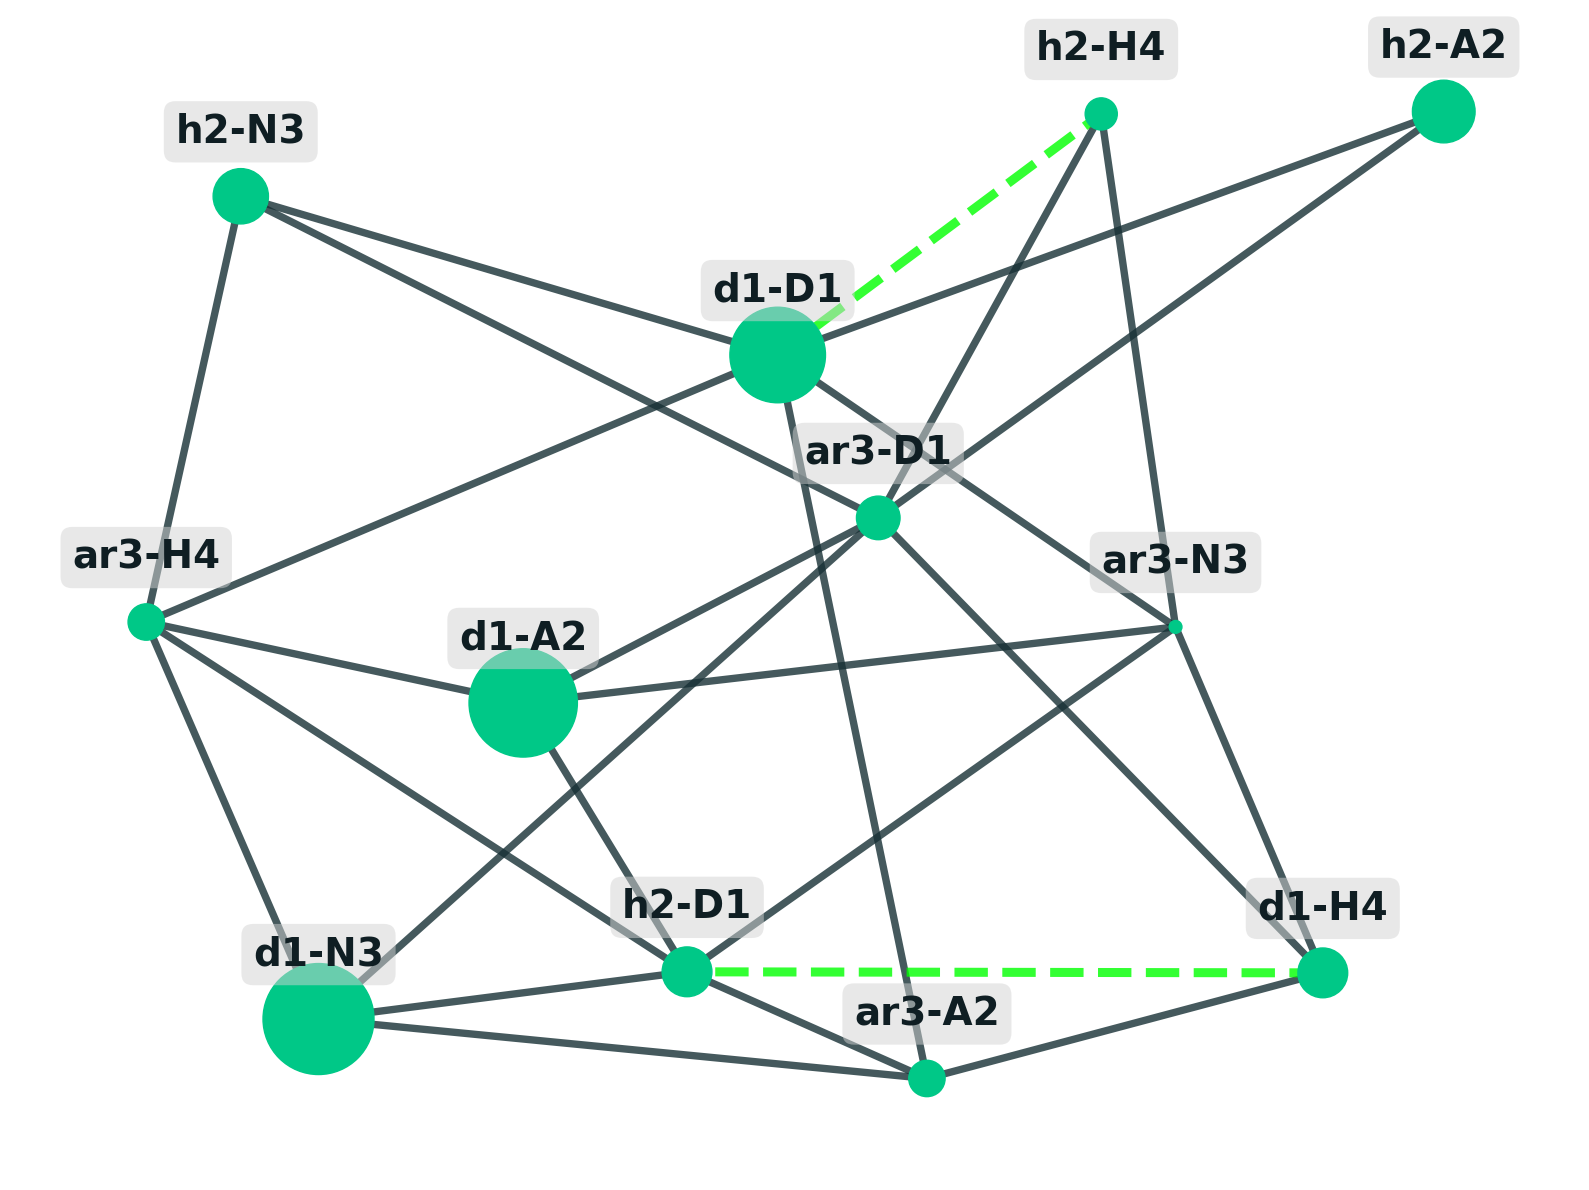

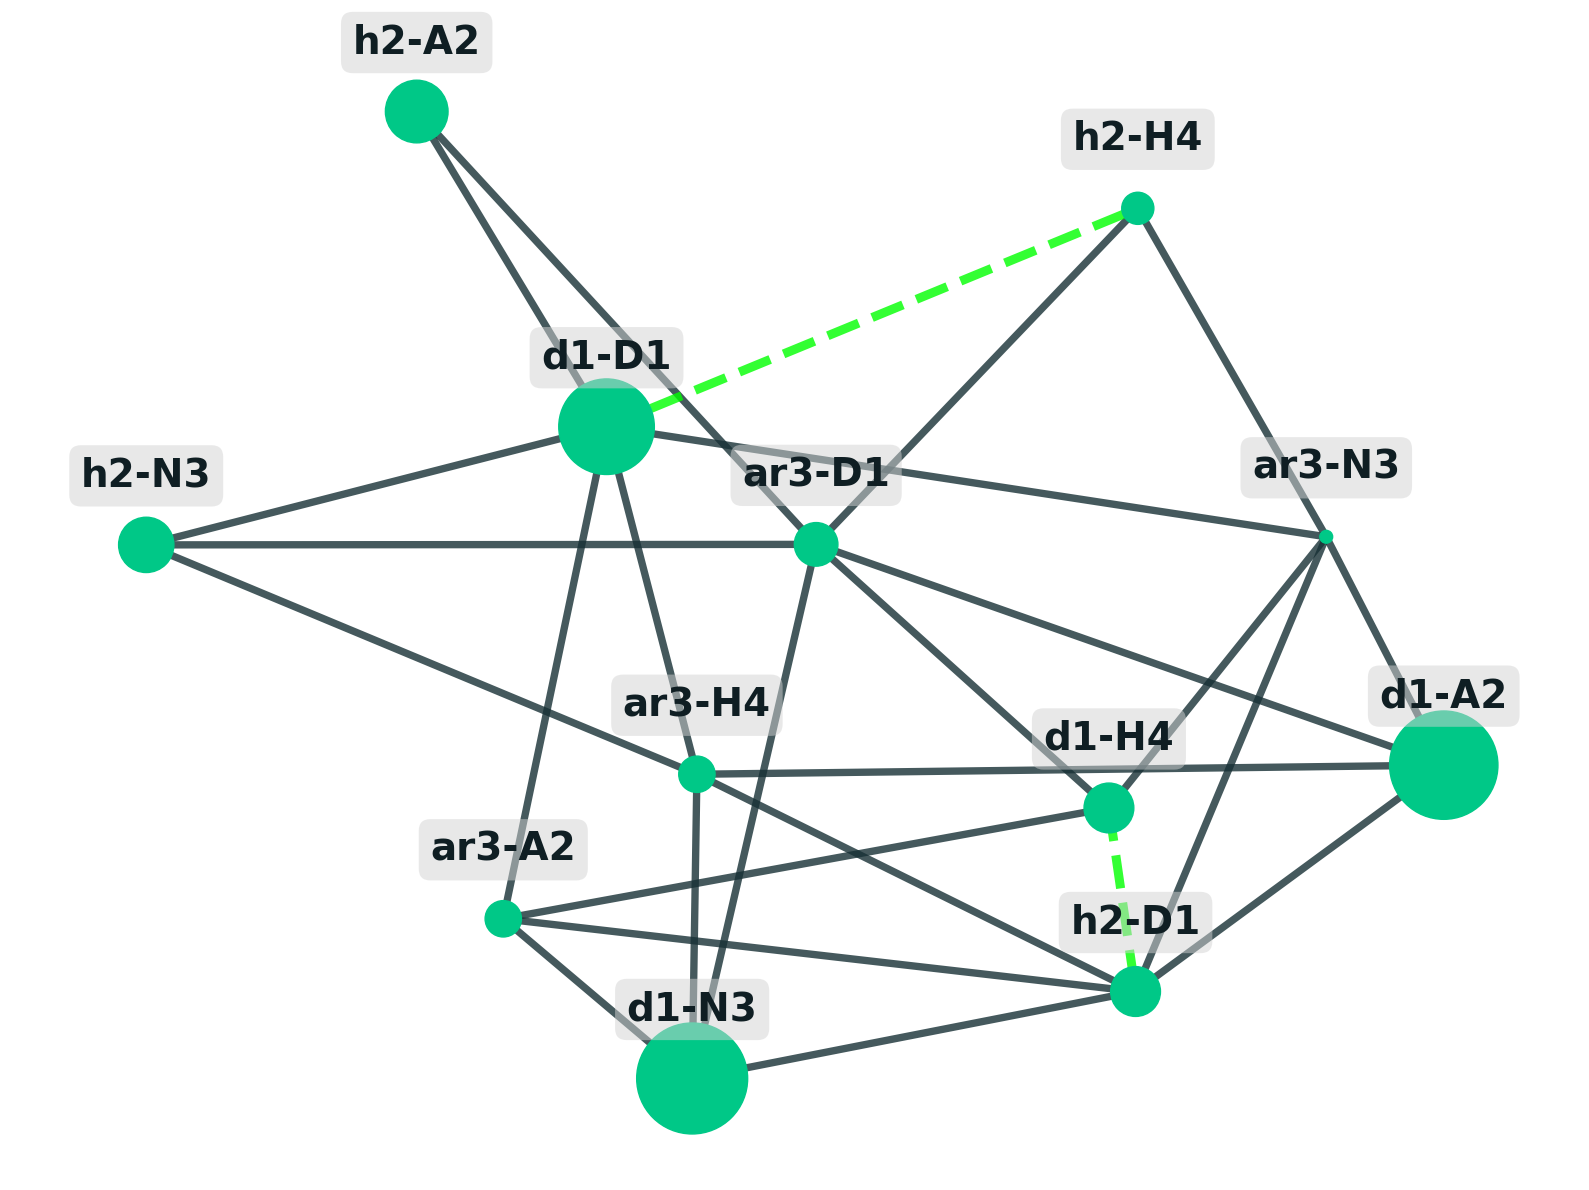

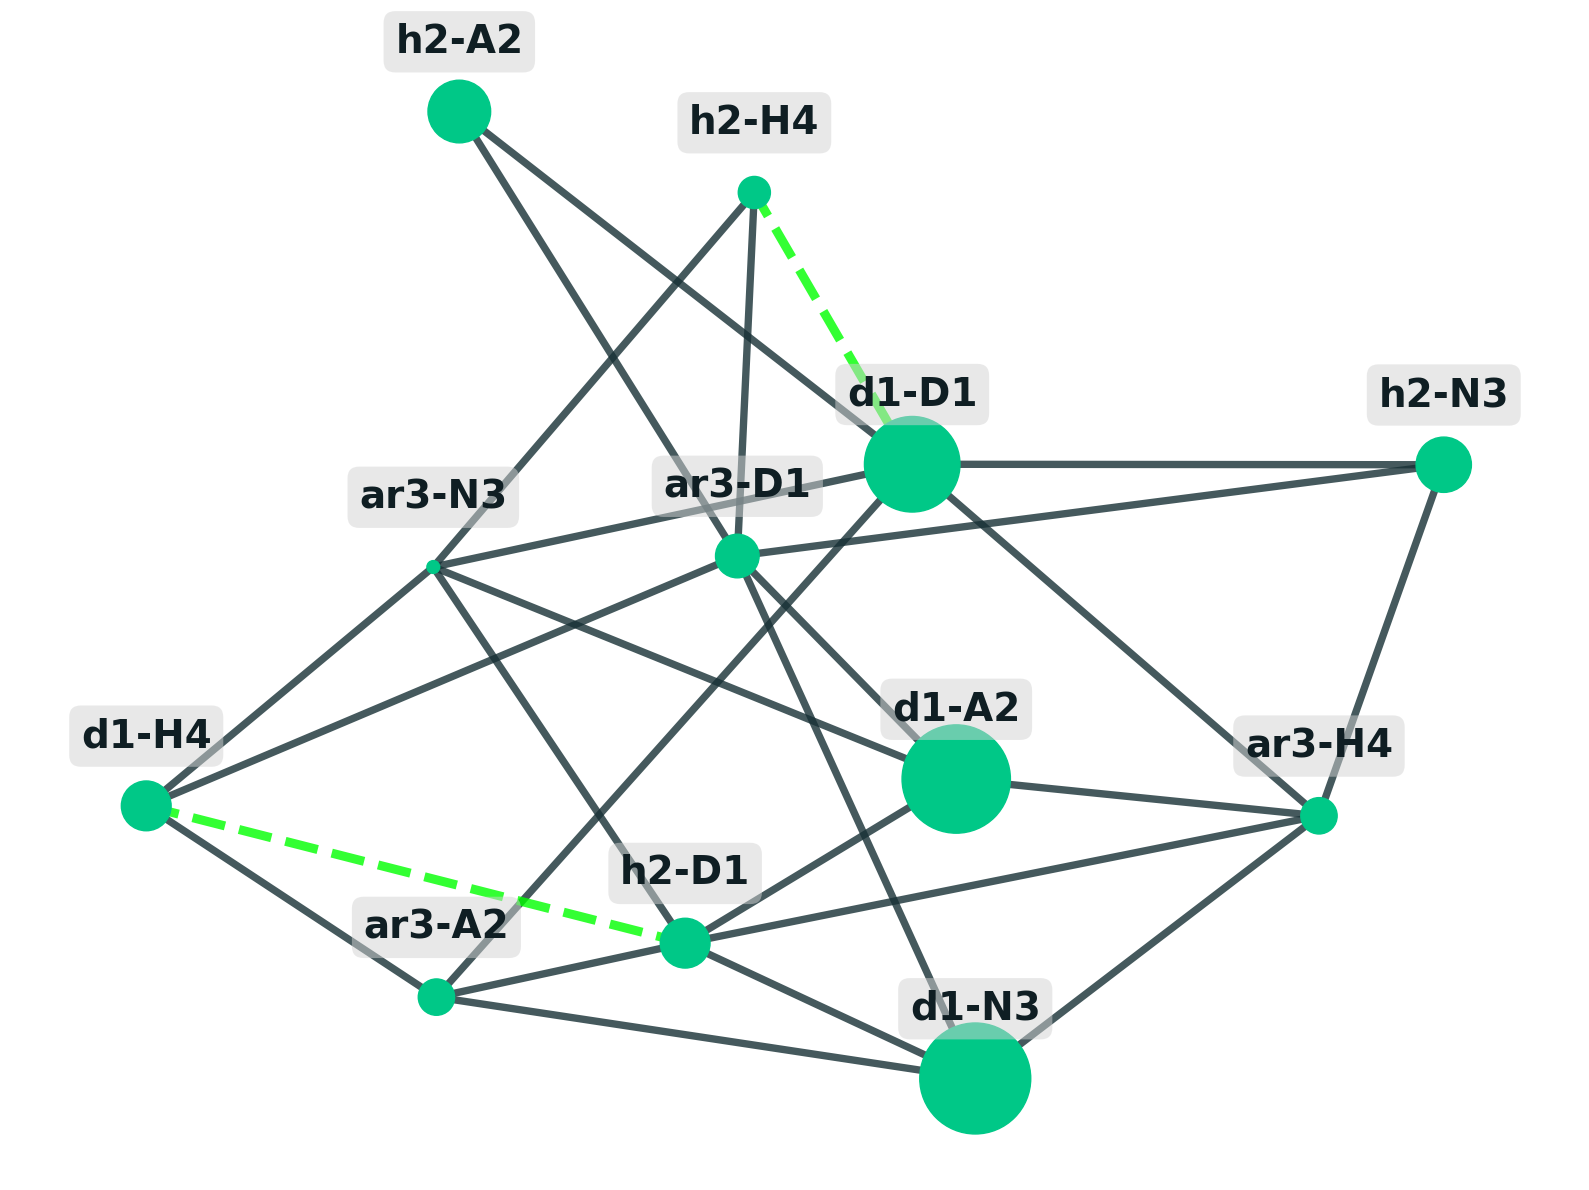

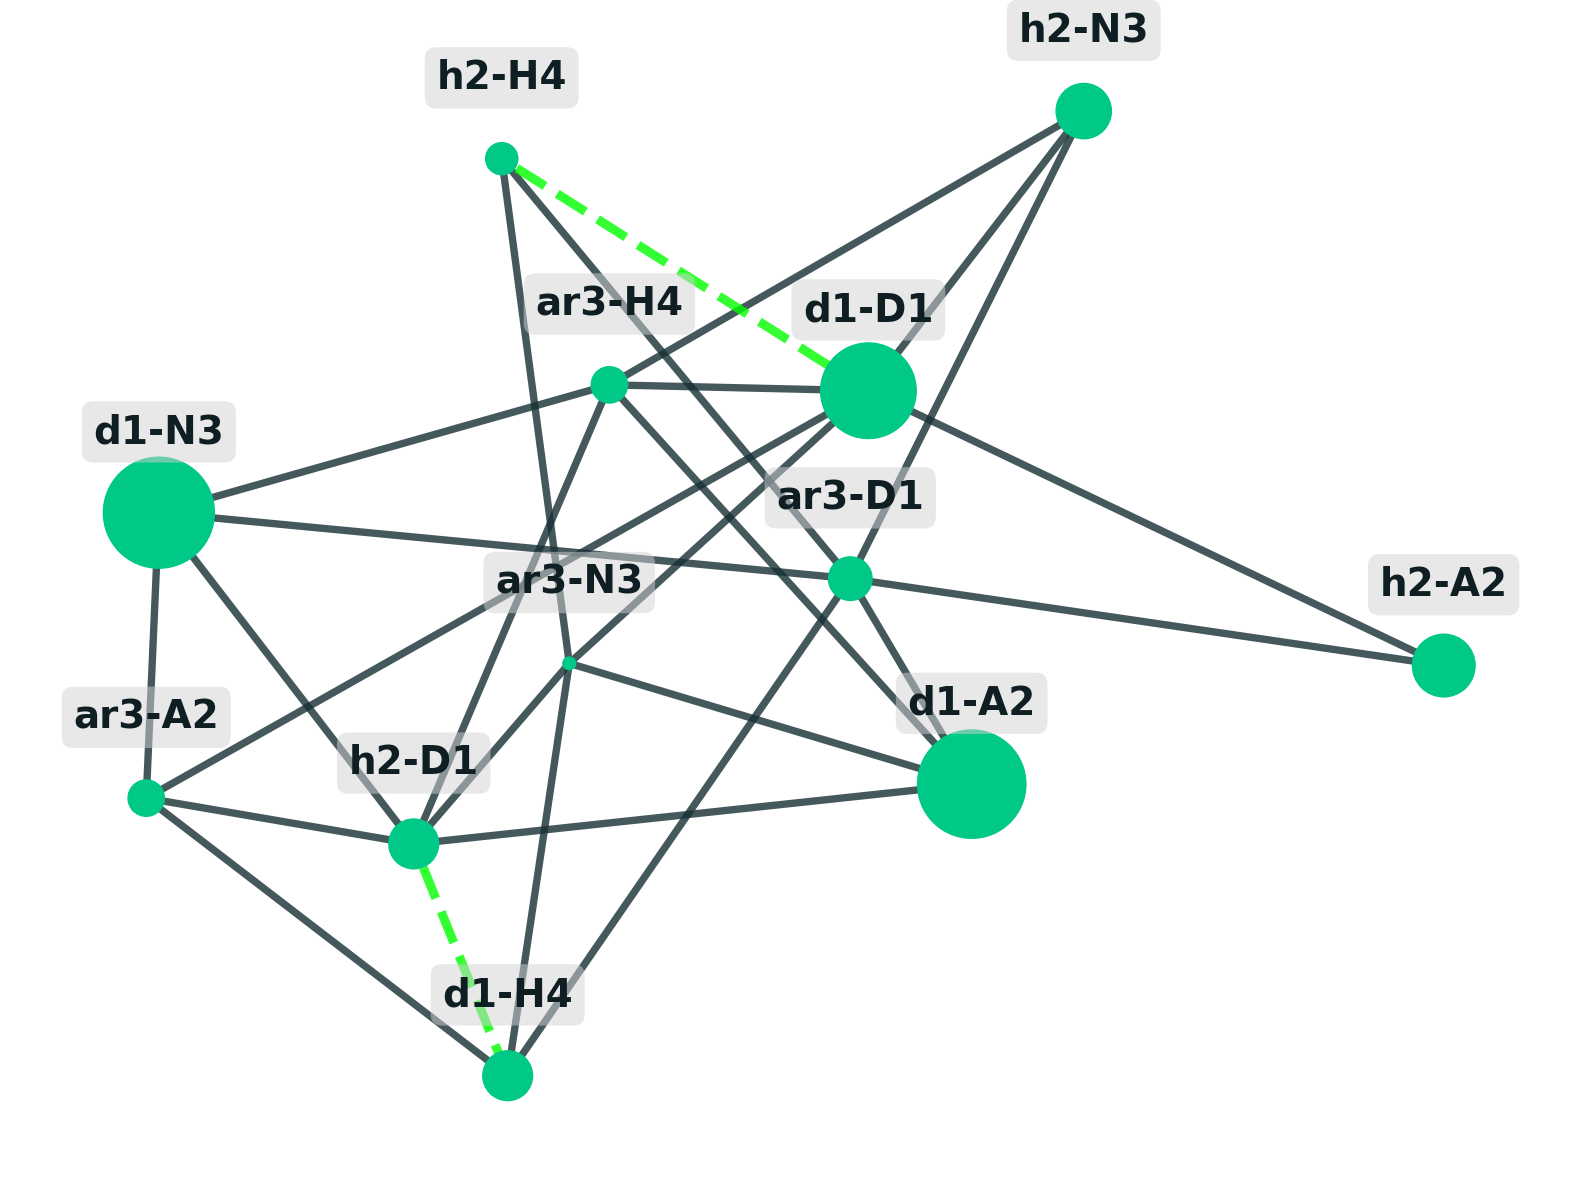

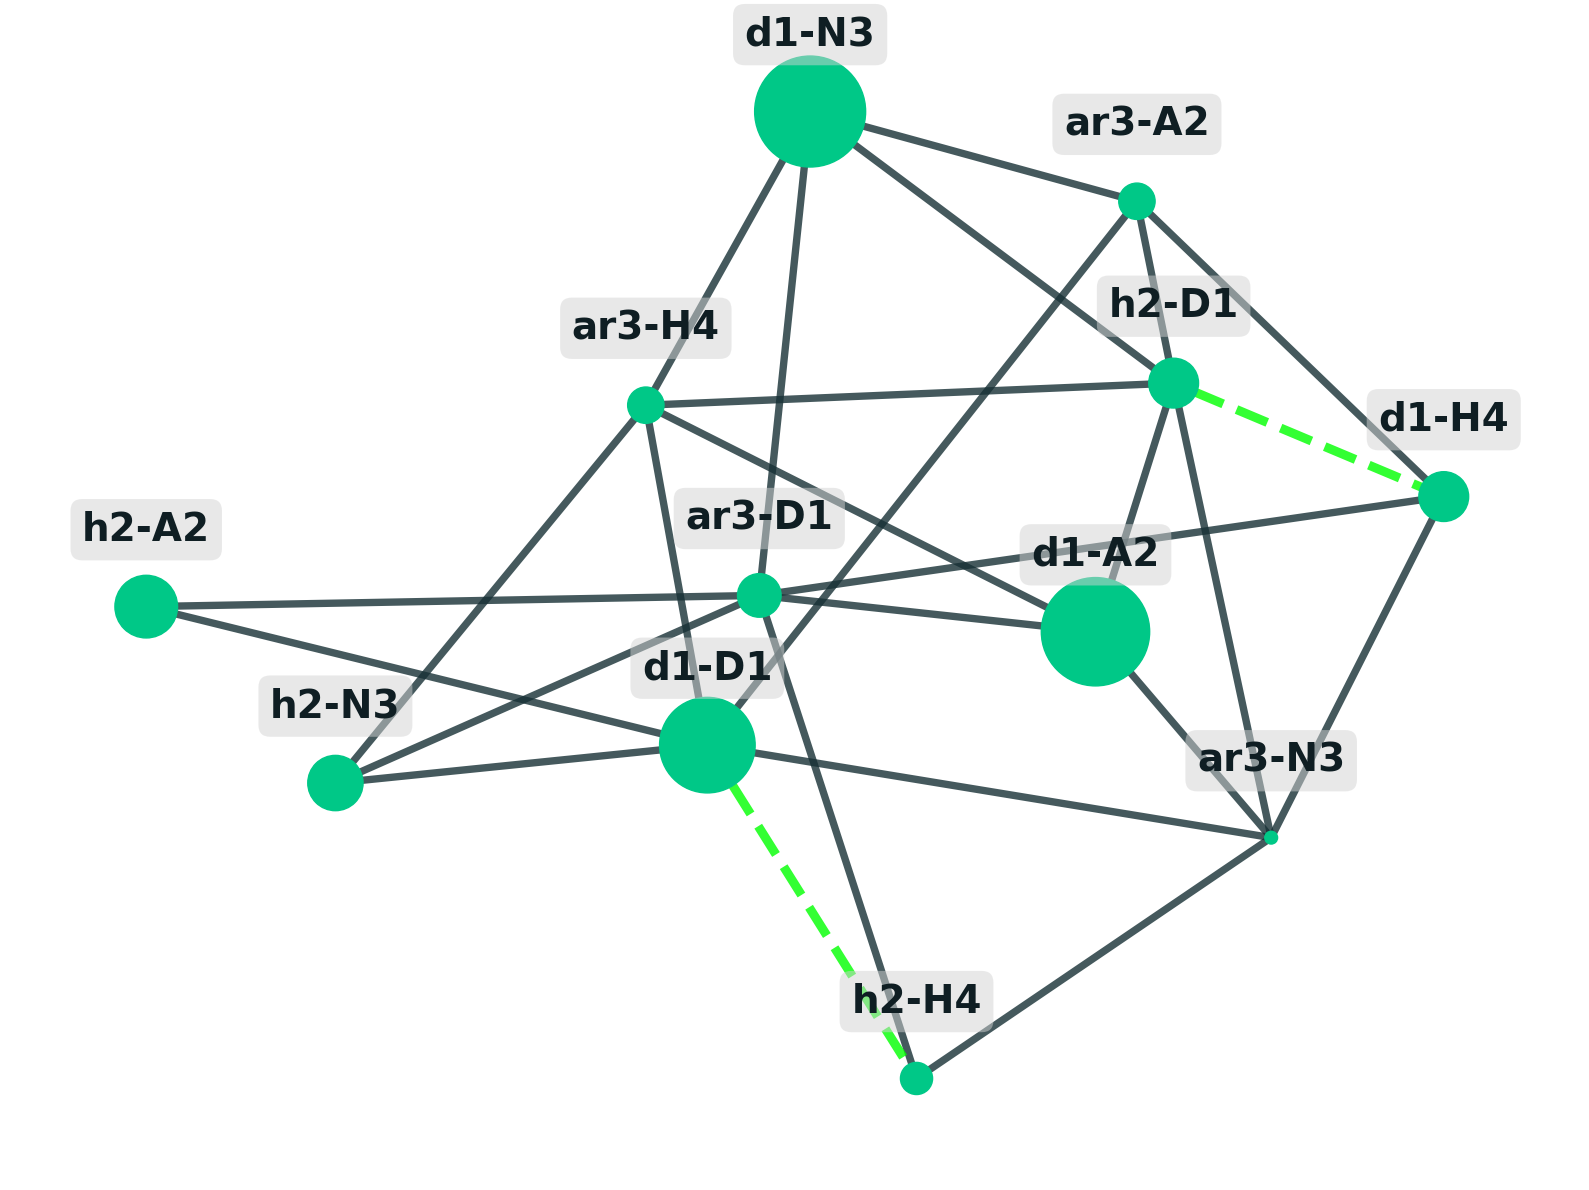

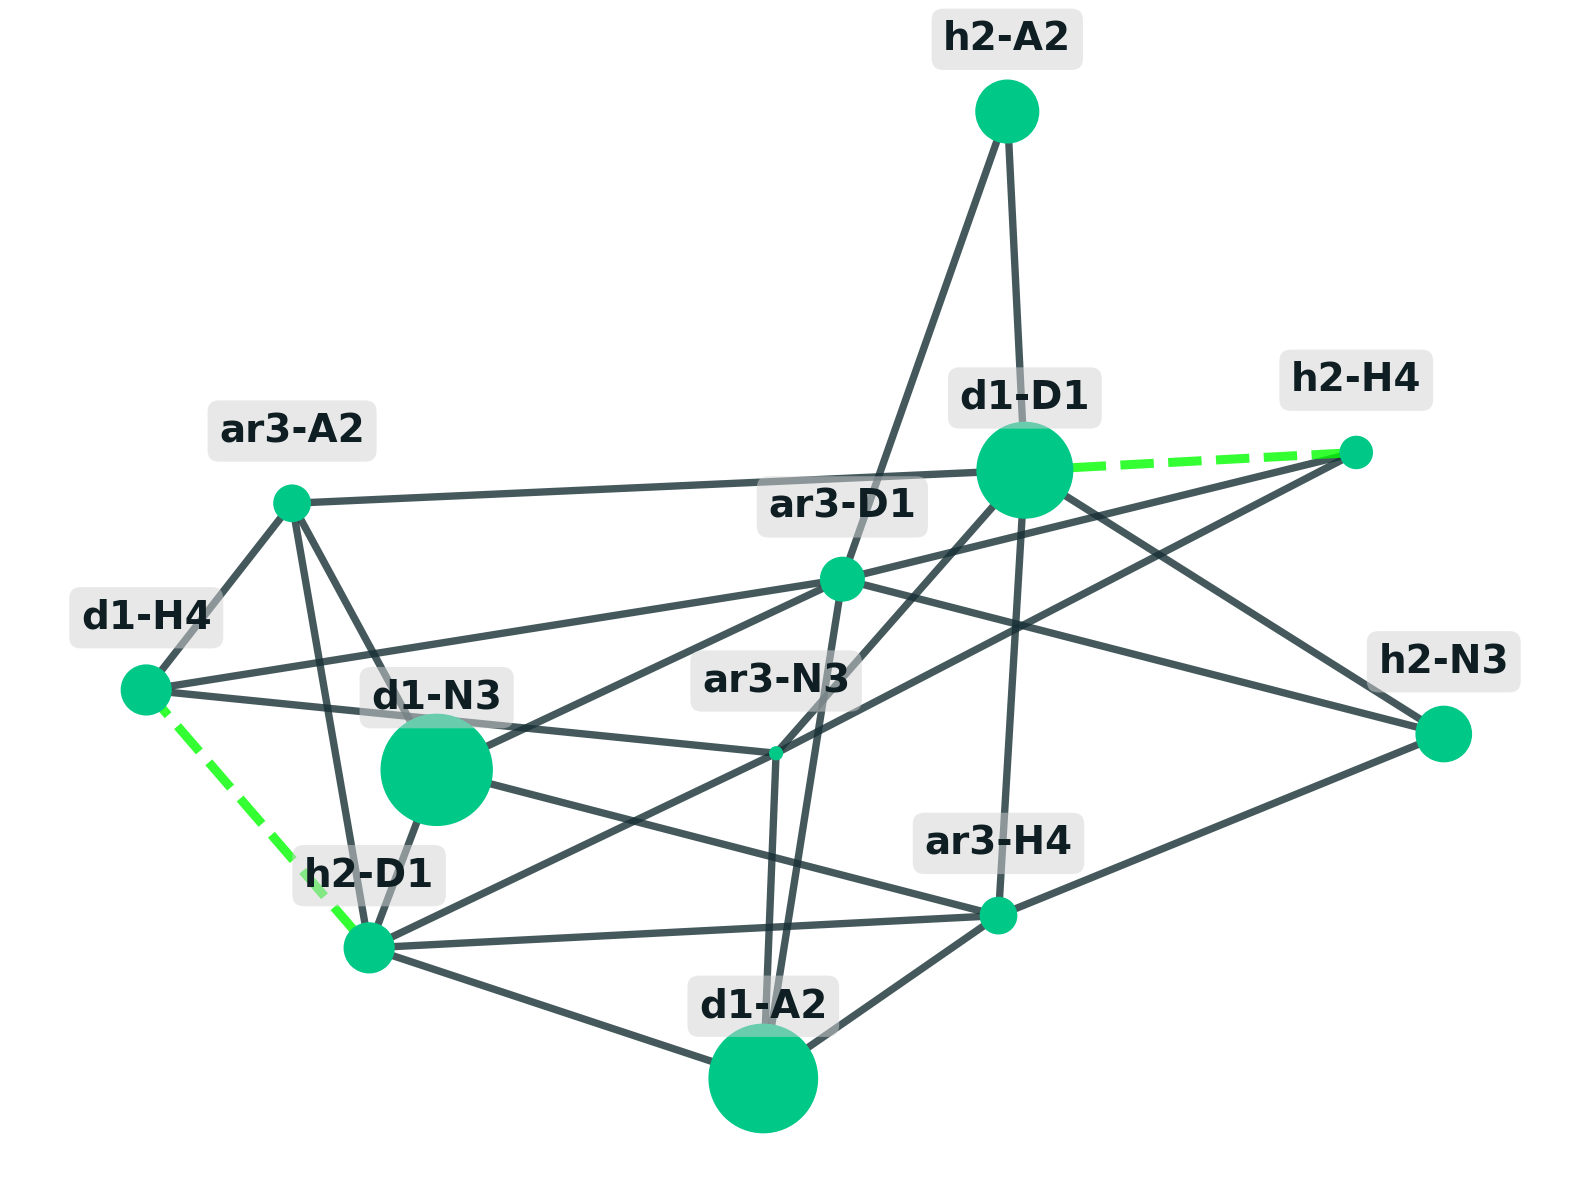

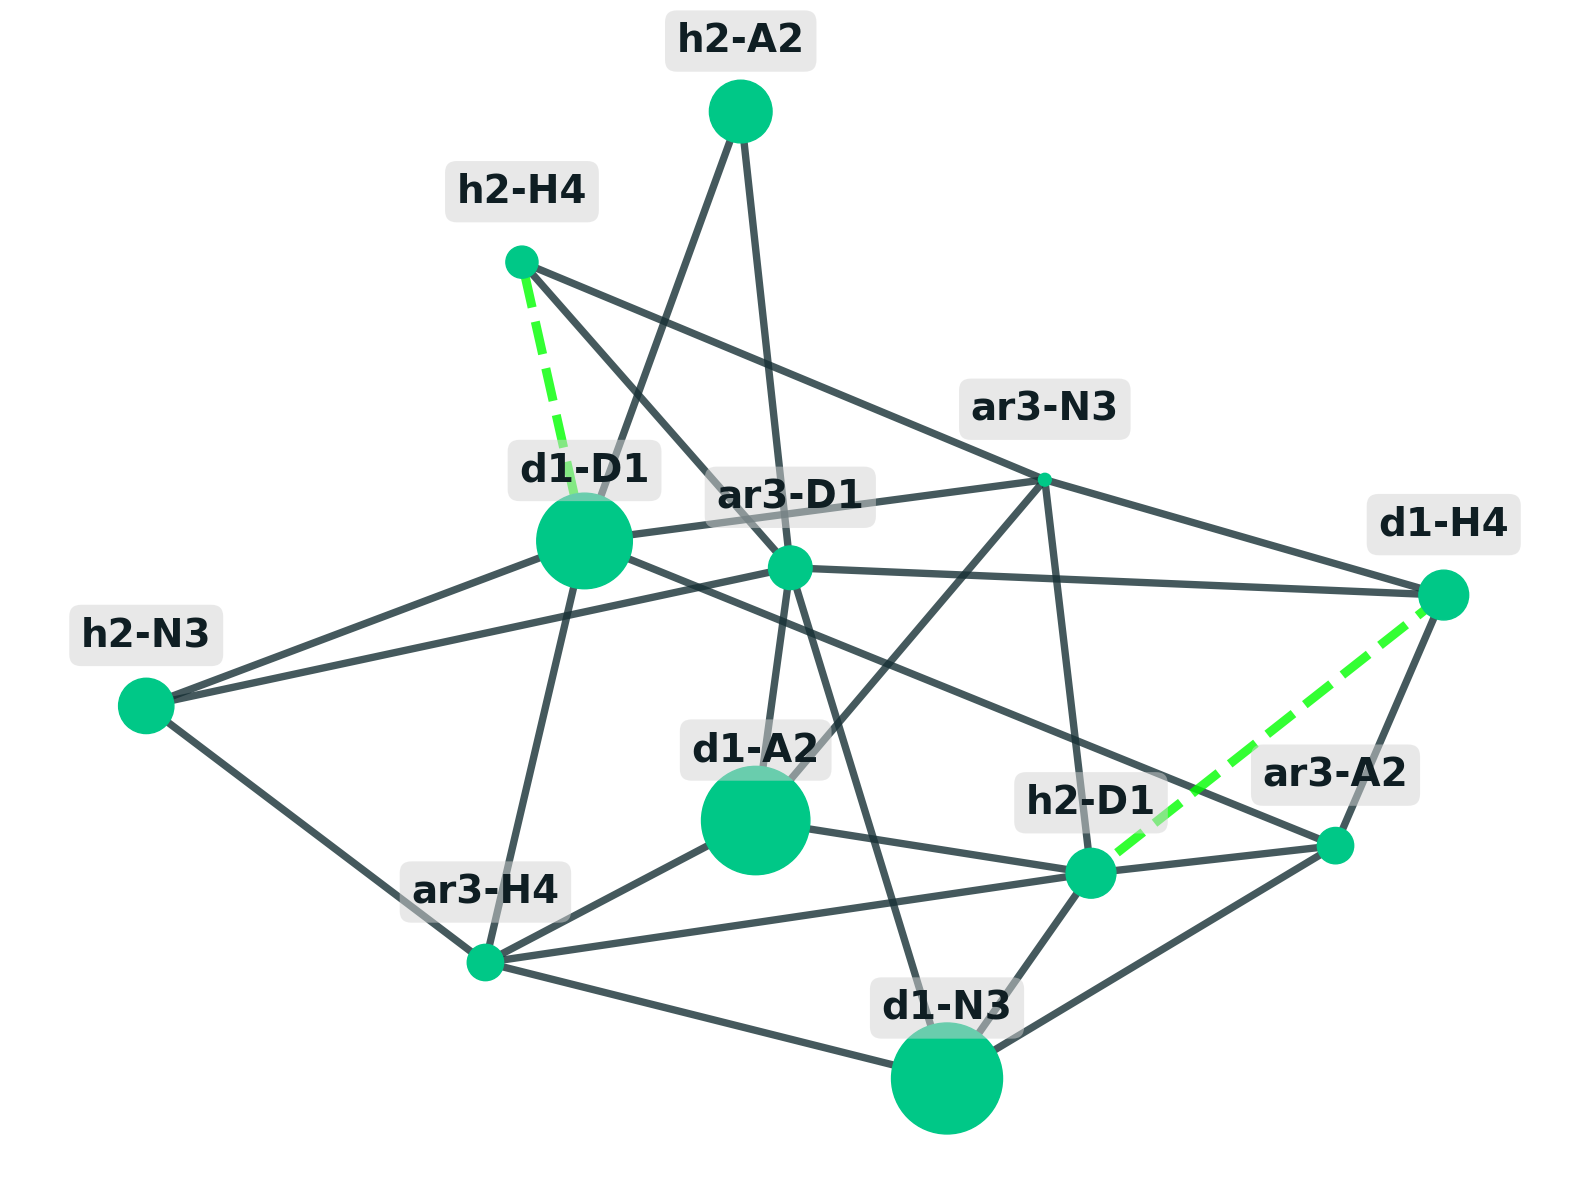

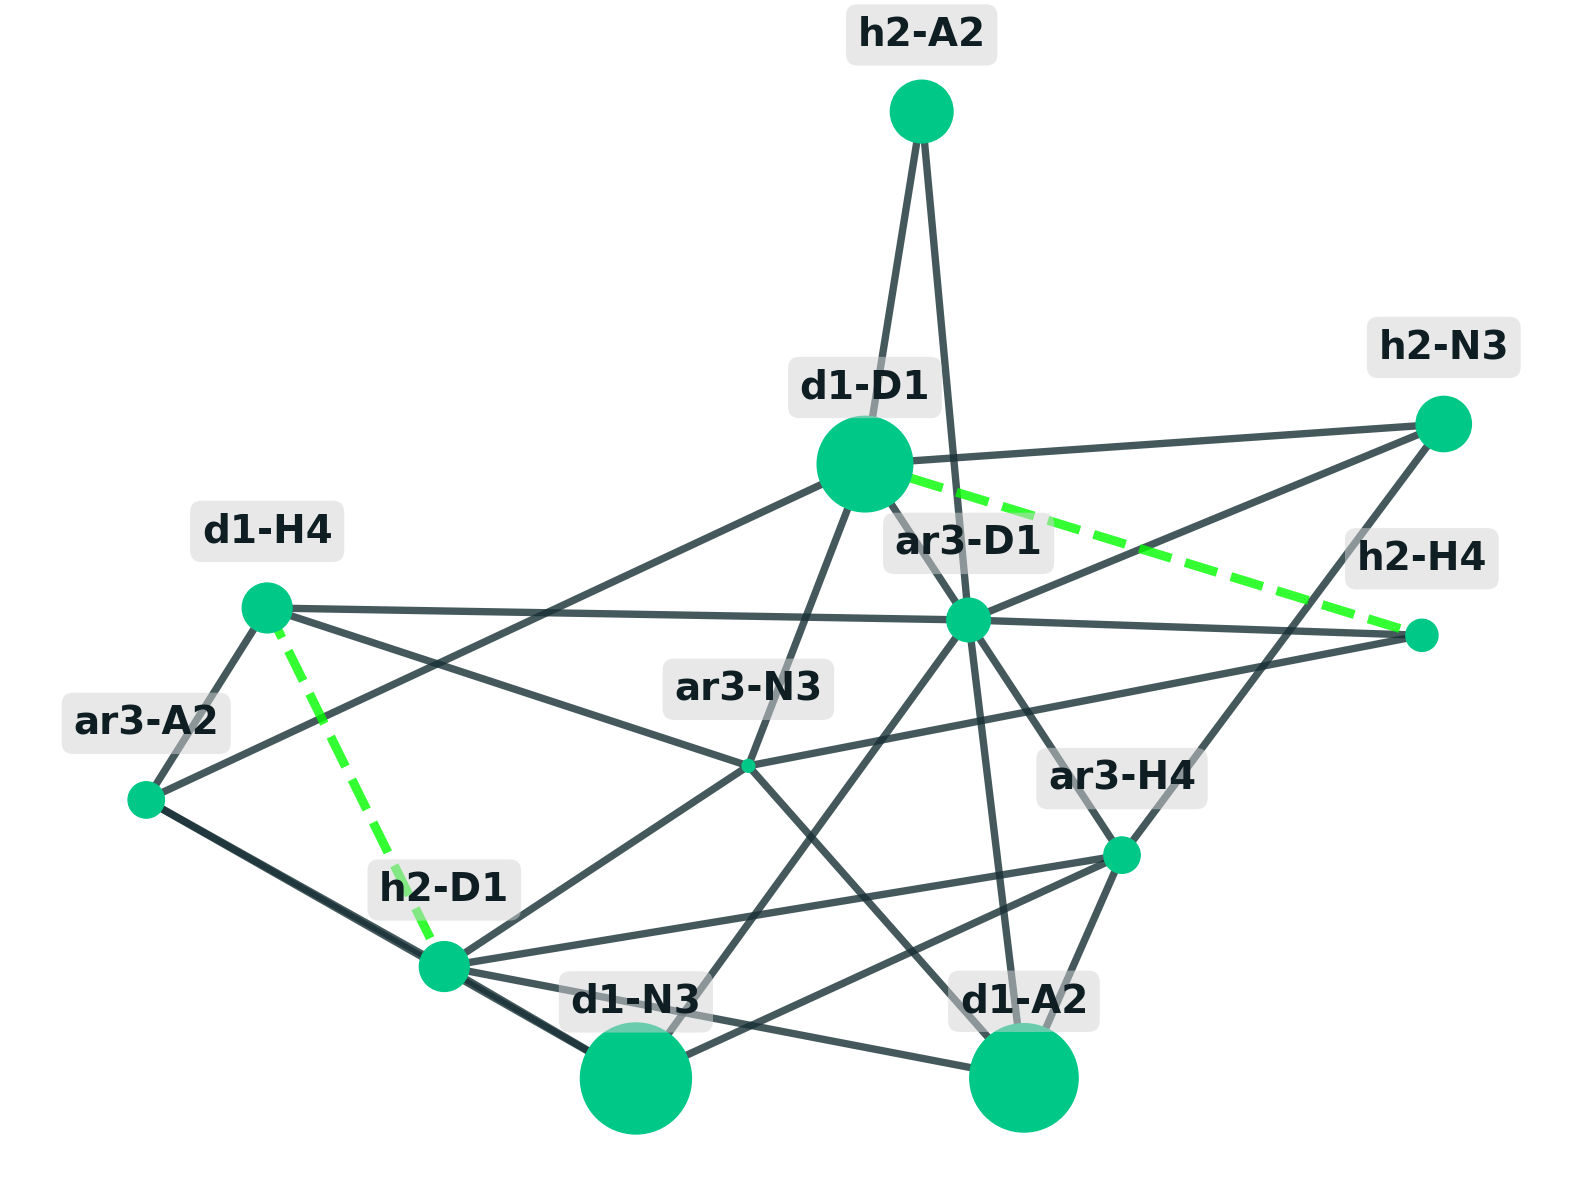

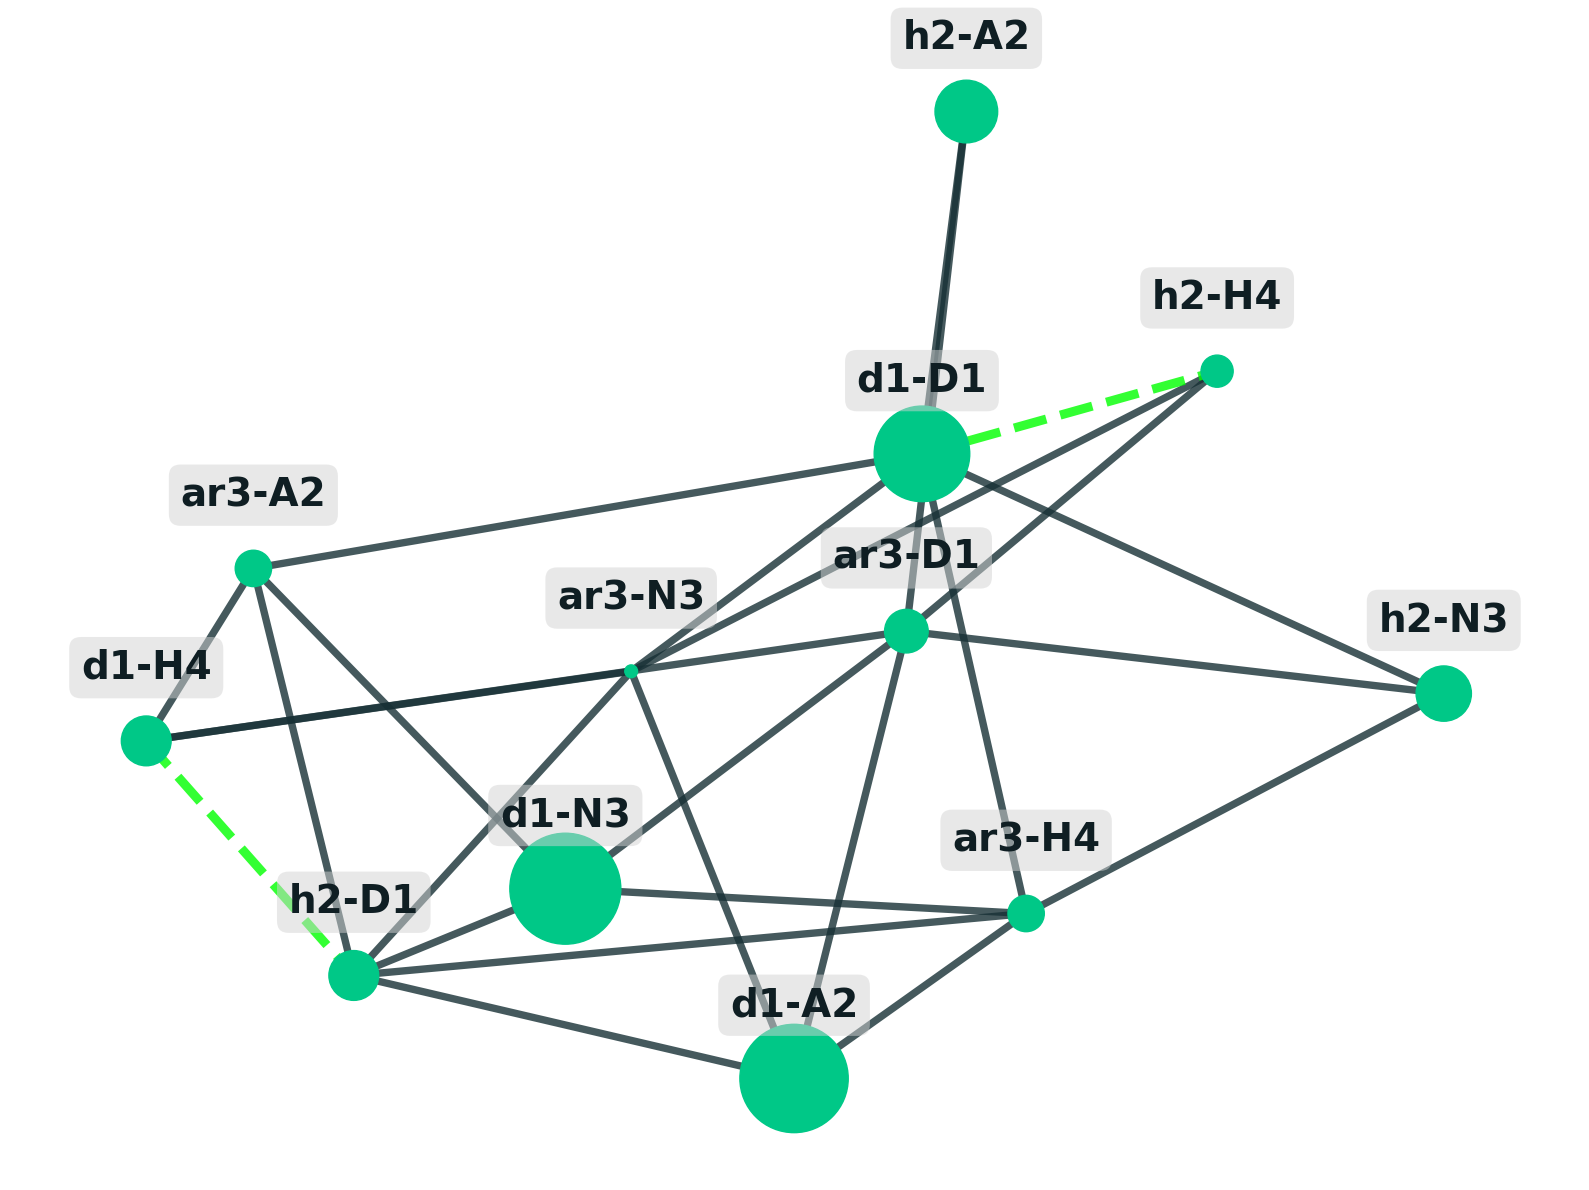

In [105]:
from random import seed
from src.draw.graph import plot_weighted_graph
from src.graph.interaction_graph import build_weighted_binding_interaction_graph


ligand_min_max_distances = find_pharmacophore_distances(ligand_conformers, l_features)
print(ligand_min_max_distances)
receptor_distance_matrix = build_distance_matrix(R_features)

interaction_graph = build_weighted_binding_interaction_graph(
    l_features, R_features, ligand_min_max_distances, receptor_distance_matrix, 1
)

for i in range (1, 10):

    create_mwc_visualizations(interaction_graph, i)

--- Running Demonstration ---
0. Creating a safe copy of the graph and preparing weights...

1. Calculating initial graph layout with seed=123...
   Layout aspect ratio is 0.88:1. Stretching horizontally to reach 1.0:1.
   Plotting graph to 'initial_graph.pdf'...
   ...Done.


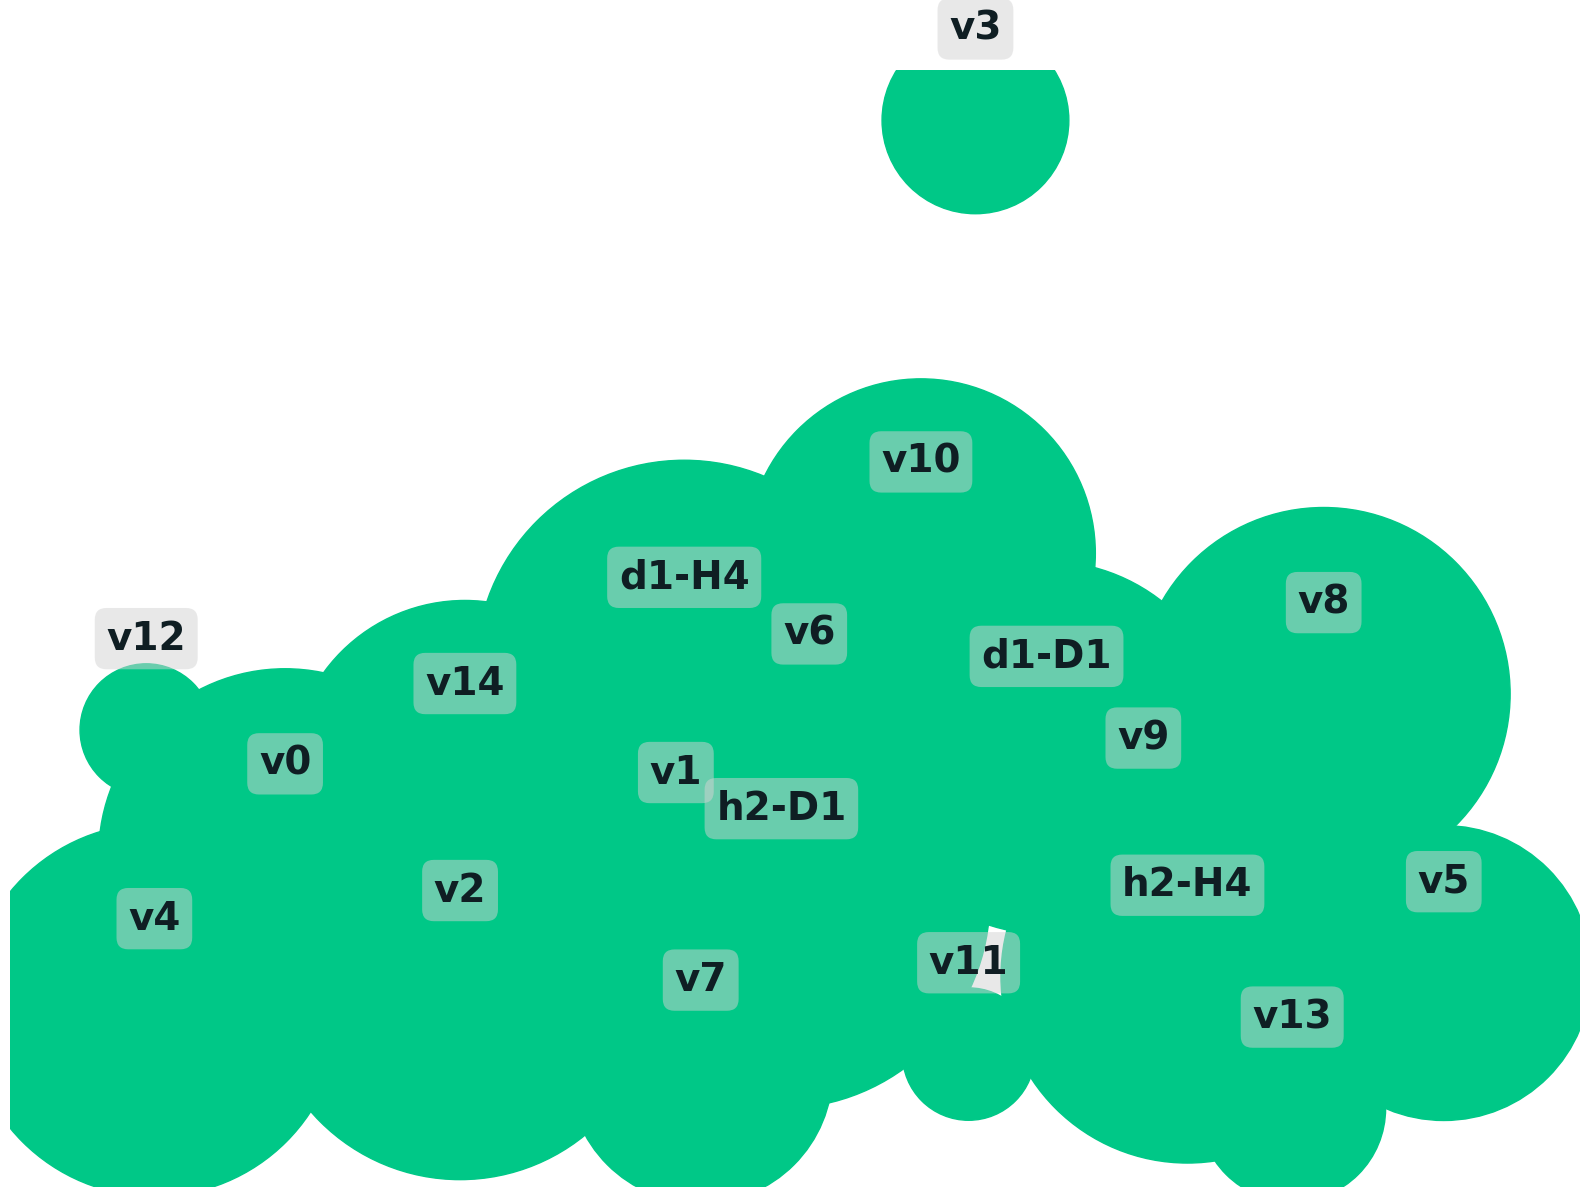


--- Demonstration Finished ---


In [104]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools

# ===================================================================
# --- GLOBAL STYLE CONFIGURATION ---
# ===================================================================

DEFAULT_NODE_COLOR_RGB = np.array([0, 200, 135])
NON_CLIQUE_NODE_COLOR_RGB = np.array([23, 48, 53])
EDGE_COLOR_RGB = np.array([23, 48, 53])
LABEL_COLOR_RGB = np.array([15, 30, 35])
SPECIAL_EDGE_COLOR_RGB = np.array([0, 255, 0])
NODE_AREA_SCALING_FACTOR = 150.0
MINIMUM_NODE_SIZE = 85.0

# ===================================================================
# --- VISUALIZATION FUNCTIONS (plot_graph et find_max_weight_clique sont inchangées) ---
# ===================================================================


def plot_graph(
    graph: nx.Graph, pos: dict, node_colors: list, special_edges: set, output_filename: str
):
    """Fonction de plot généralisée avec les derniers styles mis à jour."""
    print(f"   Plotting graph to '{output_filename}'...")

    edge_color_default = EDGE_COLOR_RGB / 255.0
    label_color = LABEL_COLOR_RGB / 255.0
    special_edge_color = SPECIAL_EDGE_COLOR_RGB / 255.0

    node_sizes = [
        MINIMUM_NODE_SIZE + graph.nodes[node]["weight"] * NODE_AREA_SCALING_FACTOR
        for node in graph.nodes()
    ]
    labels = {node: str(node) for node in graph.nodes()}

    normal_edges = [edge for edge in graph.edges() if frozenset(edge) not in special_edges]
    special_edges_list = [edge for edge in graph.edges() if frozenset(edge) in special_edges]

    fig, ax = plt.subplots(
        figsize=(16, 12)
    )  # Ajustement de la taille de la figure pour un ratio 2:1
    fig.set_facecolor("white")

    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_edges(
        graph, pos, edgelist=normal_edges, width=5.3, edge_color=edge_color_default, alpha=0.8
    )
    nx.draw_networkx_edges(
        graph,
        pos,
        edgelist=special_edges_list,
        width=6.5,
        edge_color=special_edge_color,
        alpha=0.8,
        style="--",
    )

    label_vertical_offset = 0.13  # Ajustement pour la nouvelle échelle
    for node, (x, y) in pos.items():
        ax.text(
            x,
            y + label_vertical_offset,
            labels[node],
            ha="center",
            va="center",
            fontsize=28,
            color=label_color,
            fontweight="bold",
            bbox=dict(
                facecolor="lightgray", alpha=0.5, boxstyle="round,pad=0.3", edgecolor="none"
            ),
        )

    ax.axis("off")
    plt.tight_layout()
    plt.savefig(output_filename, format="pdf", bbox_inches="tight")
    print("   ...Done.")


def find_max_weight_clique(graph: nx.Graph) -> list:
    """Trouve la clique de poids maximal en utilisant la clé 'mwc_weight'."""
    print("\n2. Calculating the Maximum Weight Clique (with scaled weights)...")
    try:
        clique, _ = nx.max_weight_clique(graph, weight="mwc_weight")
        print(f"   ...Clique found with nodes: {sorted(clique)}")
        return sorted(clique)
    except Exception as e:
        print(f"ERROR: Could not calculate Max Weight Clique. {e}")
        return []


# --- FONCTION PRINCIPALE MISE À JOUR ---
def create_mwc_visualizations(interaction_graph: nx.Graph, layout_seed: int = 42):
    """
    Fonction principale qui prend un graphe, le traite, et génère les visualisations
    en forçant un ratio d'aspect d'environ 2:1.

    Args:
        interaction_graph: Le graphe NetworkX fourni par l'utilisateur.
        layout_seed: La graine aléatoire pour la reproductibilité de la disposition.
    """
    if not isinstance(interaction_graph, nx.Graph) or not interaction_graph:
        print("ERROR: Please provide a valid, non-empty NetworkX graph.")
        return

    # --- Étape 1: Copie et nettoyage du graphe ---
    print("0. Creating a safe copy of the graph and preparing weights...")
    graph_copy = interaction_graph.copy()
    for node in graph_copy.nodes():
        original_weight = int(graph_copy.nodes[node].get("weight", 1) * 60)
        graph_copy.nodes[node]["weight"] = original_weight
        graph_copy.nodes[node]["mwc_weight"] = original_weight

    # --- Étape 2: Calculer la disposition initiale ---
    print(f"\n1. Calculating initial graph layout with seed={layout_seed}...")
    positions = nx.spring_layout(graph_copy, seed=layout_seed, k=0.9, iterations=100)

    # --- NOUVEAU: Ajuster la disposition pour forcer le ratio d'aspect ---
    pos_array = np.array(list(positions.values()))
    min_coords = pos_array.min(axis=0)
    max_coords = pos_array.max(axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    if height == 0:
        height = 1  # Éviter la division par zéro

    current_ratio = width / height
    target_ratio = 1.

    if current_ratio < target_ratio:
        print(
            f"   Layout aspect ratio is {current_ratio:.2f}:1. Stretching horizontally to reach {target_ratio}:1."
        )
        stretch_factor = target_ratio / current_ratio
        # On étire seulement l'axe X pour préserver les distances verticales
        for node, pos in positions.items():
            positions[node][0] = (pos[0] - min_coords[0]) * stretch_factor + min_coords[0]

    # --- Étape 3: Définir les arêtes spéciales ---
    special_edges = {frozenset(("d1-H4", "h2-D1")), frozenset(("d1-D1", "h2-H4"))}

    # --- Étape 4: Plot du graphe initial ---
    default_node_color_mpl = DEFAULT_NODE_COLOR_RGB / 255.0
    initial_colors = [default_node_color_mpl] * graph_copy.number_of_nodes()
    plot_graph(graph_copy, positions, initial_colors, special_edges, "initial_graph.pdf")

    # # --- Étape 5: Trouver la clique et ploter le résultat ---
    # max_clique_nodes = find_max_weight_clique(graph_copy)

    # if max_clique_nodes:
    #     print("\n3. Preparing MWC result visualization...")
    #     non_clique_color_mpl = NON_CLIQUE_NODE_COLOR_RGB / 255.0
    #     result_colors = [
    #         default_node_color_mpl if node in max_clique_nodes else non_clique_color_mpl
    #         for node in graph_copy.nodes()
    #     ]
    #     plot_graph(graph_copy, positions, result_colors, special_edges, "max_clique_result.pdf")
    # else:
    #     print("\n3. Skipping result plot because no clique was found.")


# ===================================================================
# --- EXAMPLE USAGE ---
# ===================================================================

if __name__ == "__main__":
    print("--- Running Demonstration ---")

    # Créer un graphe d'exemple
    interaction_graph = nx.Graph()
    # ... (code de création de graphe d'exemple identique à avant)
    special_nodes_data = {"d1-H4": 10, "h2-D1": 10, "d1-D1": 8, "h2-H4": 8}
    for name, weight in special_nodes_data.items():
        interaction_graph.add_node(name, weight=weight)
    for i in range(15):
        interaction_graph.add_node(f"v{i}", weight=random.randint(1, 10))
    interaction_graph.add_edge("d1-H4", "h2-D1")
    interaction_graph.add_edge("d1-D1", "h2-H4")
    nodes_list = list(interaction_graph.nodes())
    for _ in range(30):
        u, v = random.sample(nodes_list, 2)
        if not interaction_graph.has_edge(u, v):
            interaction_graph.add_edge(u, v)

    # Appeler la fonction principale avec une graine aléatoire spécifique
    create_mwc_visualizations(interaction_graph, layout_seed=123)

    plt.show()
    print("\n--- Demonstration Finished ---")

Generating a random graph with 20 nodes...
Calculating graph layout using a spring model...
Creating the plot...
Graph saved as a scalable PDF: 'publication_graph.pdf'


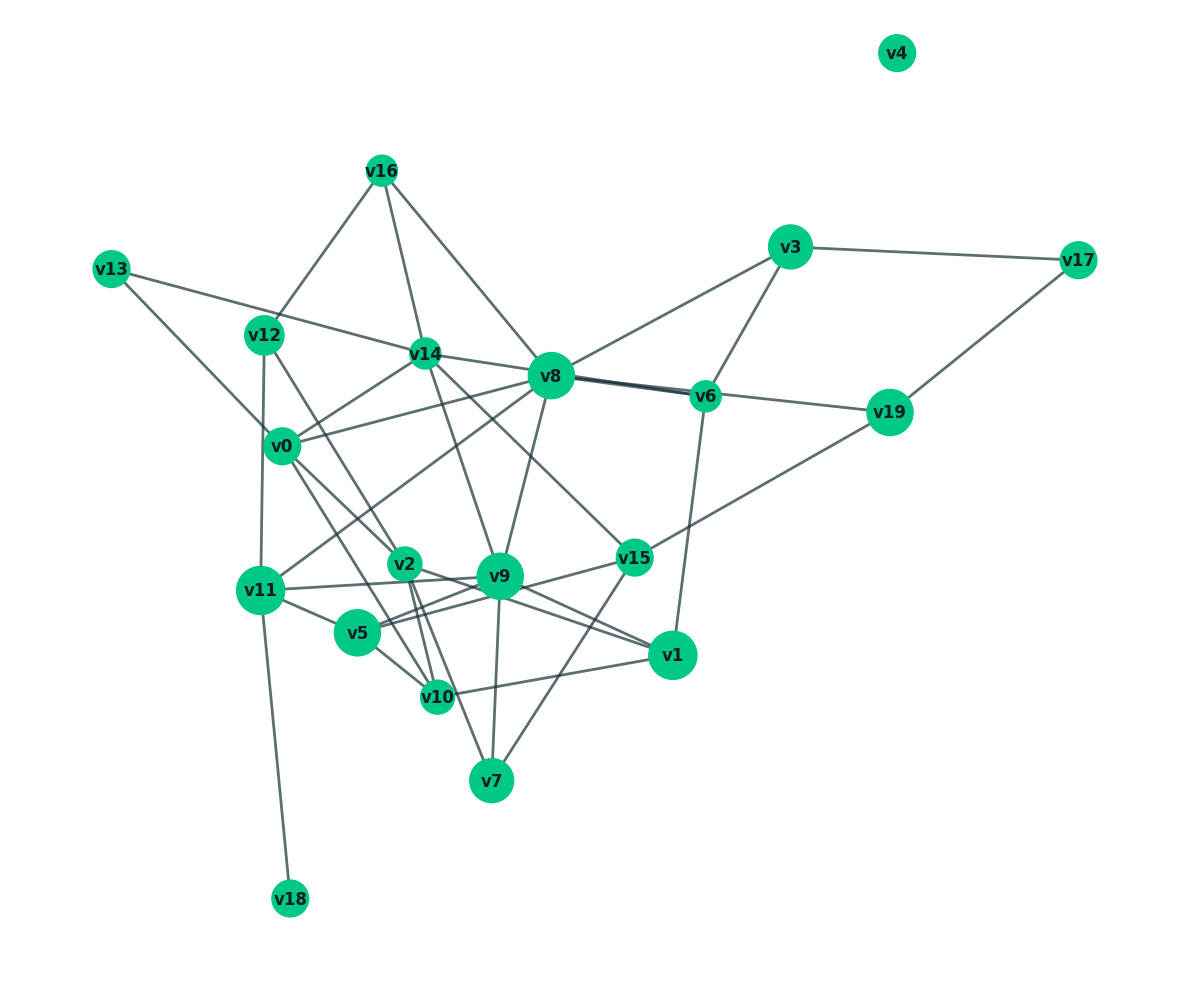

In [93]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np


def generate_publication_graph(num_nodes=20, edge_probability=0.2):
    """
    Generates and saves a publication-quality random graph in PDF format.

    This function creates a random graph, assigns weights and labels, and then
    plots it using matplotlib with a professional visual style suitable for
    academic papers, saving the output as a scalable PDF.
    """

    # 1. --- DEFINE THE VISUAL STYLE ---
    # Convert RGB values (0-255) to the matplotlib format (0-1 floats)
    node_color = np.array([0, 200, 135]) / 255.0
    edge_color = np.array([23, 48, 53]) / 255.0
    label_color = np.array([15, 30, 35]) / 255.0

    # 2. --- GENERATE A RANDOM GRAPH ---
    print(f"Generating a random graph with {num_nodes} nodes...")
    G = nx.erdos_renyi_graph(num_nodes, edge_probability, seed=42)

    for i in G.nodes():
        G.nodes[i]["weight"] = random.randint(1, 10)
        G.nodes[i]["label"] = f"v{i}"

    # 3. --- PREPARE DATA FOR PLOTTING ---
    node_sizes = [200 + G.nodes[i]["weight"] * 100 for i in G.nodes()]
    labels = {i: G.nodes[i]["label"] for i in G.nodes()}

    # Calculate node positions using a spring layout, as requested.
    # The seed ensures the layout is identical every time the code is run.
    print("Calculating graph layout using a spring model...")
    pos = nx.spring_layout(G, seed=42, k=0.8)

    # 4. --- CREATE THE PLOT ---
    print("Creating the plot...")
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.set_facecolor("white")

    # Draw the graph components
    nx.draw_networkx_nodes(
        G, pos, node_size=node_sizes, node_color=[node_color] * G.number_of_nodes()
    )

    # --- UPDATED EDGE STYLE ---
    nx.draw_networkx_edges(
        G,
        pos,
        width=2.0,  # Edges are now thicker
        edge_color=edge_color,
        alpha=0.7,  # More noticeable transparency
    )

    nx.draw_networkx_labels(
        G, pos, labels=labels, font_size=12, font_color=label_color, font_weight="bold"
    )

    # 5. --- FINALIZE AND SAVE THE FIGURE AS PDF ---
    ax.axis("off")
    plt.tight_layout()

    # --- SAVE AS PDF ---
    output_filename = "publication_graph.pdf"
    plt.savefig(output_filename, format="pdf", bbox_inches="tight", facecolor="white")
    print(f"Graph saved as a scalable PDF: '{output_filename}'")

    # Display the plot
    plt.show()


if __name__ == "__main__":
    generate_publication_graph()

Setting up the figure and graph structure...
Drawing Panel 1: Local Addressability...
Drawing Panel 2: Global Addressability...
Drawing Panel 3: Effective Local Addressability...

Figure saved as 'triptych_addressability.pdf'


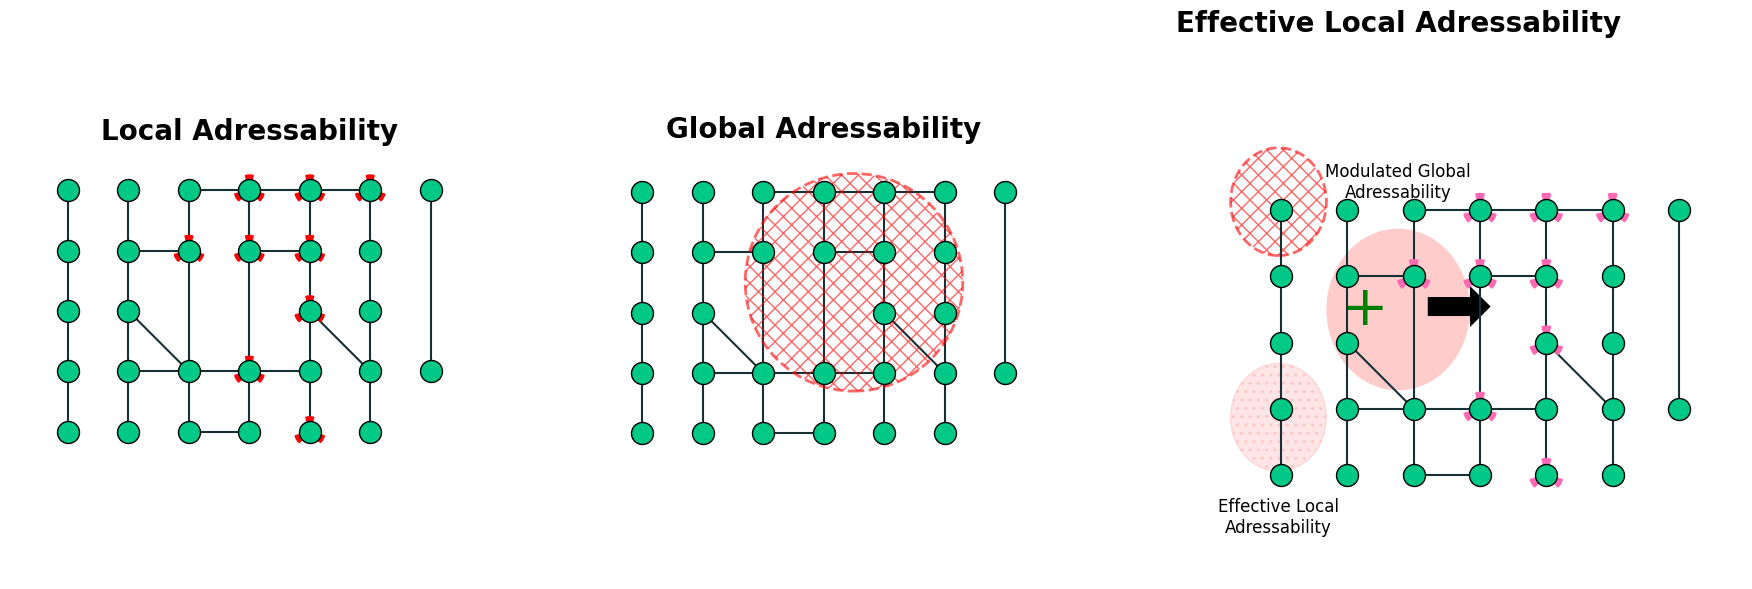

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import numpy as np

# --- Helper Functions for Custom Drawing ---

def draw_local_addressing_wedges(ax, center_pos, radius=0.25, width=0.1):
    """Draws the three inward-pointing red wedges for Local Addressability."""
    # These angles point roughly towards the center from the top, bottom-left, bottom-right
    angles = [90, 210, 330]
    for angle in angles:
        # A wedge is defined by its center, radius, start angle, and end angle
        wedge = Wedge(center_pos, radius, angle - 15, angle + 15,
                      facecolor='red', edgecolor='red', width=width)
        ax.add_patch(wedge)

def draw_effective_addressing_wedges(ax, center_pos, radius=0.25, width=0.1):
    """Draws the three outward-pointing pink wedges for Effective Local Addressability."""
    angles = [90, 210, 330]
    for angle in angles:
        # The key difference is the width is None, creating filled pie slices
        # and the color is pink.
        wedge = Wedge(center_pos, radius, angle - 15, angle + 15,
                      facecolor='#FF69B4', edgecolor='#FF69B4', width=None) # Hot pink
        ax.add_patch(wedge)

def draw_global_addressing_circle(ax, center, radius):
    """Draws the large, dashed, cross-hatched red circle."""
    circle = Circle(center, radius,
                    hatch='xx',
                    linestyle='--',
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none',
                    alpha=0.6)
    ax.add_patch(circle)

# --- Main Function to Generate the Figure ---

def create_triptych_figure():
    """
    Generates the full triptych figure based on the provided image.
    """
    print("Setting up the figure and graph structure...")

    # 1. Define the graph structure and node positions manually to match the image
    # The grid seems to be ~7 units wide and ~5 units high
    pos = {
        0:(0,4), 1:(1,4), 2:(2,4), 3:(3,4), 4:(4,4), 5:(5,4), 6:(6,4),
        7:(0,3), 8:(1,3), 9:(2,3), 10:(3,3), 11:(4,3), 12:(5,3),
        13:(0,2), 14:(1,2), 15:(4,2), 16:(5,2),
        17:(0,1), 18:(1,1), 19:(2,1), 20:(3,1), 21:(4,1), 22:(5,1), 23:(6,1),
        24:(0,0), 25:(1,0), 26:(2,0), 27:(3,0), 28:(4,0), 29:(5,0)
    }

    edges = [
        (0,7), (7,13), (13,17), (17,24),
        (1,8), (8,14), (14,18), (18,25),
        (2,9), (9,19), (19,26),
        (3,10), (10,20), (20,27),
        (4,11), (11,15), (15,21), (21,28),
        (5,12), (12,16), (16,22), (22,29),
        (6,23),
        (2,3), (3,4), (4,5),
        (8,9), (10,11),
        (14,19), (15,22),
        (18,19), (19,20), (20,21),
        (26,27)
    ]

    G = nx.Graph()
    G.add_nodes_from(pos.keys())
    G.add_edges_from(edges)

    # Common drawing options for nodes and edges
    node_options = {"node_color": "#00C887", "node_size": 250, "edgecolors": "black"}
    edge_options = {"edge_color": "#173035", "width": 1.5}

    # 2. Set up the Matplotlib figure
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    fig.set_facecolor('white')

    # --- Panel 1: Local Addressability ---
    print("Drawing Panel 1: Local Addressability...")
    ax1 = axes[0]
    nx.draw(G, pos, ax=ax1, **node_options, **edge_options)
    ax1.set_title("Local Adressability", fontsize=20, weight='bold')
    ax1.set_facecolor('#E9EFEA')

    # Add red wedges to specific nodes
    nodes_with_local_addressing = [3, 4, 5, 9, 10, 11, 15, 20, 28]
    for node_id in nodes_with_local_addressing:
        draw_local_addressing_wedges(ax1, pos[node_id])

    # --- Panel 2: Global Addressability ---
    print("Drawing Panel 2: Global Addressability...")
    ax2 = axes[1]
    nx.draw(G, pos, ax=ax2, **node_options, **edge_options)
    ax2.set_title("Global Adressability", fontsize=20, weight='bold')
    ax2.set_facecolor('#E9EFEA')

    # Add the large global addressing circle
    draw_global_addressing_circle(ax2, center=(3.5, 2.5), radius=1.8)

    # --- Panel 3: Effective Local Addressability ---
    print("Drawing Panel 3: Effective Local Addressability...")
    ax3 = axes[2]
    # This panel is a composite, so we build it piece by piece
    ax3.set_facecolor('white') # Main background is white
    ax3.set_title("Effective Local Adressability", fontsize=20, weight='bold')

    # Create an inner axes for the final graph plot
    inner_ax = fig.add_axes([0.7, 0.15, 0.25, 0.6]) # [left, bottom, width, height]
    nx.draw(G, pos, ax=inner_ax, **node_options, **edge_options)
    inner_ax.set_facecolor('#E9EFEA')

    # Add pink wedges to the final graph
    nodes_with_effective_addressing = [3, 4, 5, 9, 10, 11, 15, 20, 28]
    for node_id in nodes_with_effective_addressing:
        draw_effective_addressing_wedges(inner_ax, pos[node_id])

    # Draw the diagram components on the main axes of the third panel
    # We use axis coordinates (from 0 to 1) for easier placement
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)

    # Abstract circles
    global_circle_abstract = Circle((0.25, 0.7), 0.1, hatch='xx', linestyle='--', edgecolor='red', facecolor='none', alpha=0.6, linewidth=2)
    effective_local_abstract = Circle((0.25, 0.3), 0.1, hatch='..', edgecolor='red', facecolor='red', alpha=0.1)
    modulated_global_abstract = Circle((0.5, 0.5), 0.15, facecolor='red', alpha=0.2, edgecolor=None)

    ax3.add_patch(global_circle_abstract)
    ax3.add_patch(effective_local_abstract)
    ax3.add_patch(modulated_global_abstract)

    # Text and symbols
    ax3.text(0.38, 0.5, '+', fontsize=40, color='green', verticalalignment='center')
    ax3.text(0.55, 0.5, '➡', fontsize=60, color='black', verticalalignment='center', fontfamily='DejaVu Sans')

    ax3.text(0.5, 0.7, 'Modulated Global\nAdressability', fontsize=12, horizontalalignment='center', verticalalignment='bottom')
    ax3.text(0.25, 0.15, 'Effective Local\nAdressability', fontsize=12, horizontalalignment='center', verticalalignment='top')

    # Final cleanup
    for ax in [ax1, ax2, inner_ax]:
        ax.margins(0.1)
        ax.set_aspect('equal')

    ax3.axis('off') # Turn off axis for the diagram part

    # 4. Save the figure
    output_filename = "triptych_addressability.pdf"
    plt.savefig(output_filename, format='pdf', bbox_inches='tight')
    print(f"\nFigure saved as '{output_filename}'")
    plt.show()


if __name__ == '__main__':
    create_triptych_figure()

In [15]:
from src.graph.interaction_graph import build_distance_matrix
from src.mol_processing.features import find_pharmacophore_distances

from src.draw.mol import visualize_flexibility_ensemble
from src.mol_processing.mol import generate_aligned_conformers

ligand_conformers = generate_aligned_conformers(ligand)

ligand_min_max_distances = find_pharmacophore_distances(ligand_conformers, ligand_features)
receptor_distance_matrix = build_distance_matrix(receptor_features)

flex_view = visualize_flexibility_ensemble(ligand_conformers, num_to_display=40)
flex_view

Generated and aligned 100 conformers on the specified core.
(Feature(l_d_0), Feature(l_d_0))
(Feature(l_d_0), Feature(l_a_0))
(Feature(l_d_0), Feature(l_a_1))
(Feature(l_d_0), Feature(l_a_2))
(Feature(l_d_0), Feature(l_ar_0))
(Feature(l_d_0), Feature(l_h_0))
(Feature(l_d_0), Feature(l_h_1))
(Feature(l_d_0), Feature(l_h_2))
(Feature(l_d_0), Feature(l_h_3))
(Feature(l_d_0), Feature(l_h_4))
(Feature(l_d_0), Feature(l_h_5))
(Feature(l_d_0), Feature(l_h_6))
(Feature(l_d_0), Feature(l_h_7))
(Feature(l_d_0), Feature(l_h_8))
(Feature(l_d_0), Feature(l_h_9))
(Feature(l_a_0), Feature(l_a_0))
(Feature(l_a_0), Feature(l_a_1))
(Feature(l_a_0), Feature(l_a_2))
(Feature(l_a_0), Feature(l_ar_0))
(Feature(l_a_0), Feature(l_h_0))
(Feature(l_a_0), Feature(l_h_1))
(Feature(l_a_0), Feature(l_h_2))
(Feature(l_a_0), Feature(l_h_3))
(Feature(l_a_0), Feature(l_h_4))
(Feature(l_a_0), Feature(l_h_5))
(Feature(l_a_0), Feature(l_h_6))
(Feature(l_a_0), Feature(l_h_7))
(Feature(l_a_0), Feature(l_h_8))
(Feature(l_a_0

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from src.draw.mol import visualize_min_max_distance_pair


visualize_min_max_distance_pair(ligand_conformers, ligand_min_max_distances)


Pair with largest variation: (l_d_0, l_h_4)
  Min distance: 7.45 Å (Conformer ID: 26)
  Max distance: 14.99 Å (Conformer ID: 47)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from src.draw.graph import plot_weighted_graph
from src.graph.interaction_graph import build_weighted_binding_interaction_graph


ligand_min_max_distances = find_pharmacophore_distances(ligand_conformers, ligand_features)
receptor_distance_matrix = build_distance_matrix(R_features)

interaction_graph = build_weighted_binding_interaction_graph(
    ligand_features, R_features, ligand_min_max_distances, receptor_distance_matrix, 1
)
plot_weighted_graph(interaction_graph)

KeyboardInterrupt: 

In [ ]:
print(interaction_graph.number_of_edges())
print(interaction_graph.number_of_nodes())
print(
    2 * interaction_graph.number_of_edges()
    / (interaction_graph.number_of_nodes()
    * (interaction_graph.number_of_nodes() - 1))
)

44876
540
0.3083625369339655


In [ ]:
# Assume the necessary classes (Feature, FeatureFamily) and imports are defined.
import py3Dmol
from rdkit import Chem
import numpy as np

from src.mol_processing.features import Feature


def visualize_contact_placement(
    placed_ligand: Chem.Mol,
    receptor: Chem.Mol,
    receptor_features: list[Feature],
    contacts: list[tuple[str, str]],
) -> py3Dmol.view:
    """
    Displays the result of a ligand placement, highlighting the matched contacts.
    This version uses a robust method for styling and model handling.
    """
    view = py3Dmol.view(width=1400, height=1000)

    # Add ligand as model 0 and style it
    view.addModel(Chem.MolToMolBlock(placed_ligand), "mol")
    view.setStyle({"model": 0}, {"stick": {}})

    # Add receptor as model 1 and style it
    # Using PDB format is more robust for protein cartoon rendering
    view.addModel(Chem.MolToPDBBlock(receptor), "pdb")
    view.setStyle({"model": 1}, {"cartoon": {"color": "lightgray", "opacity": 0.6}})

    ligand_features = extract_pharmacophores(placed_ligand, "l")

    # Add all pharmacophore features as spheres
    all_features = ligand_features + receptor_features
    for feature in all_features:
        pos = feature.position
        view.addSphere(
            {
                "center": {"x": pos[0], "y": pos[1], "z": pos[2]},
                "radius": 0.6,
                "color": feature.family.color,
                "alpha": 0.85,
            }
        )

    # Create maps for easy feature lookup by name
    ligand_feature_map = {f.name: f for f in ligand_features}
    receptor_feature_map = {f.name: f for f in receptor_features}

    # Draw dashed green lines for the specified contacts
    for lig_name, rec_name in contacts:
        if lig_name in ligand_feature_map and rec_name in receptor_feature_map:
            pos1 = ligand_feature_map[lig_name].position
            pos2 = receptor_feature_map[rec_name].position
            view.addCylinder(
                {
                    "start": {"x": pos1[0], "y": pos1[1], "z": pos1[2]},
                    "end": {"x": pos2[0], "y": pos2[1], "z": pos2[2]},
                    "color": "green",
                    "radius": 0.08,
                    "dashed": True,
                }
            )

    # Zoom to frame all visible objects in the scene
    view.zoomTo()

    return view


In [ ]:
from src.mol_processing.postprocessing import place_ligand_from_contacts
from src.solver.classical import greedy_max_weight_clique


clique = greedy_max_weight_clique(interaction_graph, min_clique_size=15)
print(clique)
final_interactions = []
for interaction in clique:
    features = interaction.split("-")
    final_interactions.append((features[0], features[1]))


docked_ligand = place_ligand_from_contacts(ligand, receptor_features, contacts=final_interactions)
visualize_contact_placement(
    docked_ligand,
    receptor,
    receptor_features,
    final_interactions,
)

['l_h_6-R_d_363', 'l_a_1-R_d_361', 'l_a_0-R_d_314', 'l_a_2-R_d_360', 'l_d_0-R_d_364', 'l_h_3-R_a_295', 'l_h_9-R_a_298', 'l_h_8-R_a_298', 'l_h_4-R_a_297', 'l_h_2-R_a_295', 'l_ar_0-R_ar_6', 'l_h_9-R_d_316', 'l_h_2-R_d_313', 'l_h_7-R_d_363', 'l_h_3-R_d_313', 'l_h_8-R_d_316', 'l_ar_0-R_d_313', 'l_h_3-R_ar_6', 'l_ar_0-R_a_295', 'l_h_0-R_h_293']
Best solution: RMSD = 8.549 Å for conformer 0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from src.solver.classical import find_exhaustive_weighted_max_clique

from src.mol_processing.postprocessing import place_ligand_from_contacts

cliques = find_exhaustive_weighted_max_clique(interaction_graph)

In [ ]:
clique, weight = cliques

print(len(clique), weight)
print(clique)

18 5.404
['l_a_0-R_d_222', 'l_a_1-R_a_298', 'l_a_1-R_d_316', 'l_a_2-R_a_297', 'l_ar_0-R_d_223', 'l_d_0-R_a_295', 'l_d_0-R_ar_6', 'l_d_0-R_d_313', 'l_h_1-R_a_213', 'l_h_2-R_d_223', 'l_h_3-R_d_223', 'l_h_4-R_d_221', 'l_h_5-R_a_213', 'l_h_6-R_ar_6', 'l_h_6-R_d_314', 'l_h_7-R_d_314', 'l_h_8-R_d_220', 'l_h_9-R_d_220']


In [ ]:
exhaustive = [
    "l_a_0-R_d_222",
    "l_a_1-R_a_298",
    "l_a_1-R_d_316",
    "l_a_2-R_a_297",
    "l_ar_0-R_d_223",
    "l_d_0-R_a_295",
    "l_d_0-R_ar_6",
    "l_d_0-R_d_313",
    "l_h_1-R_a_213",
    "l_h_2-R_d_223",
    "l_h_3-R_d_223",
    "l_h_4-R_d_221",
    "l_h_5-R_a_213",
    "l_h_6-R_ar_6",
    "l_h_6-R_d_314",
    "l_h_7-R_d_314",
    "l_h_8-R_d_221",
    "l_h_9-R_d_220",
]


final_interactions = []
for interaction in exhaustive:
    features = interaction.split("-")
    final_interactions.append((features[0], features[1]))


max_ligand = place_ligand_from_contacts(ligand_conformers, receptor_features, final_interactions, 10)
rmsd = calculate_docking_rmsd(ligand, max_ligand)
print(rmsd)

visualize_contact_placement(
    max_ligand,
    receptor,
    receptor_features,
    final_interactions,
)

New best pose: 18 contacts, Score=0.237 (Conf ID: 0)
7.537843587781688


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from src.graph.mapping import build_complementary_graph
import networkx as nx

compl = build_complementary_graph(interaction_graph)
initial = build_complementary_graph(compl)
nx.write_graphml(compl, f"../data/instances/3A_TACE_AS_COMPL.graphml")
nx.write_graphml(initial, f"../data/instances/3A_TACE_AS.graphml")

In [ ]:
quantum_result = [
    "l_h_7-R_ar_6",
    "l_a_2-R_a_298",
    "l_a_1-R_a_297",
    "l_h_0-R_d_223",
    "l_h_1-R_a_213",
    "l_h_7-R_d_314",
    "l_h_6-R_d_314",
    "l_ar_0-R_a_213",
    "l_a_0-R_d_222",
    "l_h_4-R_d_221",
    "l_d_0-R_d_313",
    "l_d_0-R_a_295",
    "l_a_2-R_d_316",
    "l_h_6-R_ar_6",
    "l_h_8-R_d_221",
    "l_h_9-R_d_220",
]

final_interactions = []
for interaction in quantum_result:
    features = interaction.split("-")
    final_interactions.append((features[0], features[1]))


quantum_ligand = place_ligand_from_contacts(
    ligand_conformers, receptor_features, contacts=final_interactions
)

if quantum_ligand is not None:
    # Only call the visualization function if the placement was successful
    print("\nPlacement successful. Generating visualization...")
    visualize_contact_placement(
        quantum_ligand,
        receptor,
        receptor_features,
        final_interactions,
    )
else:
    # Handle the failure case gracefully
    print("\nPlacement failed. Cannot generate visualization because no valid pose was found.")
visualize_contact_placement(
    quantum_ligand,
    receptor,
    receptor_features,
    final_interactions,
)

Could not find a valid placement for any conformer.

Placement failed. Cannot generate visualization because no valid pose was found.


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToMolBlock(NoneType)
did not match C++ signature:
    MolToMolBlock(RDKit::ROMol mol, bool includeStereo=True, int confId=-1, bool kekulize=True, bool forceV3000=False)
    MolToMolBlock(RDKit::ROMol mol, RDKit::MolWriterParams params, int confId=-1)

In [ ]:
# --- Imports and Function Definitions ---
# Run this cell once to define the necessary functions.

import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol


def calculate_docking_rmsd(ref_mol: Chem.Mol, prb_mol: Chem.Mol) -> float:
    """
    Calculates the RMSD between two molecules without alignment.
    This is the correct method for evaluating docking pose accuracy.
    """
    if ref_mol.GetNumAtoms() != prb_mol.GetNumAtoms():
        raise ValueError("Molecules must have the same number of atoms.")

    ref_coords = ref_mol.GetConformer(0).GetPositions()
    prb_coords = prb_mol.GetConformer(0).GetPositions()

    squared_diffs = (ref_coords - prb_coords) ** 2
    rmsd = np.sqrt(np.mean(np.sum(squared_diffs, axis=1)))

    return rmsd


def visualize_docking_result(
    receptor: Chem.Mol, ref_ligand: Chem.Mol, prb_ligand: Chem.Mol
) -> py3Dmol.view:
    """
    Visualizes a receptor and two superimposed ligands (e.g., crystal vs. docked).
    Uses the PDB format for robustness.
    """
    rmsd = calculate_docking_rmsd(ref_ligand, prb_ligand)
    view = py3Dmol.view(width=1400, height=1000)

    # Convert each molecule to a PDB-formatted text block
    receptor_pdb = Chem.MolToPDBBlock(receptor)
    ref_ligand_pdb = Chem.MolToPDBBlock(ref_ligand)
    prb_ligand_pdb = Chem.MolToPDBBlock(prb_ligand)

    # Add models, specifying the 'pdb' format
    view.addModel(receptor_pdb, "pdb")  # Model 0
    view.addModel(ref_ligand_pdb, "pdb")  # Model 1
    view.addModel(prb_ligand_pdb, "pdb")  # Model 2

    # Apply styles to each model by its index
    view.setStyle({"model": 0}, {"cartoon": {"color": "lightgray", "opacity": 0.7}})
    view.setStyle({"model": 1}, {"stick": {"colorscheme": "magentaCarbon"}})
    view.setStyle({"model": 2}, {"stick": {"colorscheme": "greenCarbon"}})

    # Add the RMSD label
    ref_coords = prb_ligand.GetConformer(0).GetPositions()
    ligand_center = np.mean(ref_coords, axis=0)

    view.addLabel(
        f"RMSD: {rmsd:.2f} Å",
        {
            "position": {"x": ligand_center[0], "y": ligand_center[1], "z": ligand_center[2]},
            "backgroundColor": "white",
            "fontColor": "black",
        },
    )

    view.zoomTo({"model": [1, 2]})
    return view

In [ ]:
import numpy as np
from rdkit import Chem


def calculate_docking_rmsd(ref_mol: Chem.Mol, prb_mol: Chem.Mol) -> float:
    """
    Calculates the RMSD between two molecules (e.g., a crystal ligand and a
    docked ligand) without performing any alignment.

    Args:
        ref_mol: The reference molecule (e.g., from a crystal structure).
        prb_mol: The probe molecule (e.g., the output from a docking run).

    Returns:
        The calculated RMSD value as a float (in Ångströms).
    """
    if ref_mol.GetNumAtoms() != prb_mol.GetNumAtoms():
        raise ValueError("Molecules must have the same number of atoms.")

    # Get the coordinates from the first conformer of each molecule
    ref_coords = ref_mol.GetConformer(0).GetPositions()
    prb_coords = prb_mol.GetConformer(0).GetPositions()

    # Calculate the squared differences
    squared_diffs = (ref_coords - prb_coords) ** 2

    # Calculate the mean of the sum of squared differences, then take the square root
    rmsd = np.sqrt(np.mean(np.sum(squared_diffs, axis=1)))

    return rmsd


# --- Step 1: Load the molecules ---
# These molecules are already positioned in the binding site's coordinate frame.
crystal_ligand = ligand
docked_ligand = docked_ligand

# Check if loading was successful
if crystal_ligand is None or docked_ligand is None:
    raise IOError("Could not load one or both molecule files.")

# --- Step 2: Calculate the docking RMSD ---
# We use our new function that does NOT align the molecules.
docking_accuracy_rmsd = calculate_docking_rmsd(crystal_ligand, docked_ligand)

print(f"Docking RMSD: {docking_accuracy_rmsd:.3f} Å")

# --- Step 3: Interpret the result ---
if docking_accuracy_rmsd < 2.0:
    print("Result: This is considered a successful docking pose!")
else:
    print("Result: The predicted pose deviates significantly from the experimental structure.")

Docking RMSD: 8.194 Å
Result: The predicted pose deviates significantly from the experimental structure.


In [ ]:
visualize_docking_result(receptor, ligand, prb_ligand=quantum_ligand)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
visualize_docking_result(receptor, ligand, prb_ligand=max_ligand)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# cplex_result = [
#     "l_d_0-R_a_295",
#     "l_d_0-R_ar_6",
#     "l_d_0-R_d_313",
#     "l_a_0-R_d_222",
#     "l_a_1-R_a_297",
#     "l_a_2-R_d_316",
#     "l_a_2-R_a_298",
#     "l_ar_0-R_d_223",
#     "l_h_1-R_a_213",
#     "l_h_2-R_d_223",
#     "l_h_3-R_d_223",
#     "l_h_4-R_d_221",
#     "l_h_5-R_a_213",
#     "l_h_6-R_ar_6",
#     "l_h_6-R_d_314",
#     "l_h_7-R_d_314",
#     "l_h_8-R_d_220",
#     "l_h_9-R_d_220",
# ]

cplex_result = [
    "l_h_8-R_h_62",
    "l_a_2-R_d_222",
    "l_a_2-R_d_223",
    "l_d_0-R_a_298",
    "l_a_0-R_d_314",
    "l_a_0-R_d_312",
    "l_d_0-R_a_213",
    "l_a_0-R_d_313",
    "l_a_1-R_d_316",
    "l_a_1-R_d_223",
    "l_a_1-R_d_222",
    "l_d_0-R_a_297",
    "l_a_2-R_d_316",
    "l_a_2-R_a_298",
    "l_a_2-R_a_213",
    "l_a_1-R_a_213",
    "l_a_0-R_a_295",
    "l_a_1-R_a_298",
    "l_d_0-R_d_223",
    "l_d_0-R_d_224",
    "l_d_0-R_d_316",
    "l_h_1-R_a_295",
    "l_h_2-R_a_297",
    "l_h_9-R_a_295",
    "l_h_3-R_a_295",
    "l_h_6-R_a_213",
    "l_h_2-R_a_295",
    "l_a_0-R_h_293",
    "l_h_7-R_a_297",
    "l_h_3-R_a_297",
    "l_h_2-R_a_298",
    "l_h_3-R_a_298",
    "l_h_5-R_a_297",
    "l_h_8-R_a_295",
    "l_h_0-R_a_298",
    "l_a_2-R_h_252",
    "l_h_7-R_a_298",
    "l_a_1-R_h_252",
    "l_h_1-R_a_297",
    "l_h_5-R_a_298",
    "l_h_6-R_a_298",
    "l_h_7-R_a_213",
    "l_h_0-R_a_295",
    "l_h_6-R_a_297",
    "l_h_0-R_a_297",
    "l_h_1-R_a_298",
    "l_ar_0-R_ar_6",
    "l_h_9-R_d_360",
    "l_h_5-R_d_314",
    "l_h_2-R_d_316",
    "l_d_0-R_h_253",
    "l_h_3-R_d_314",
    "l_h_4-R_d_312",
    "l_h_1-R_d_314",
    "l_h_8-R_d_360",
    "l_h_0-R_d_313",
    "l_h_9-R_d_313",
    "l_h_3-R_d_313",
    "l_h_5-R_d_316",
    "l_h_1-R_d_313",
    "l_h_7-R_d_223",
    "l_h_7-R_d_224",
    "l_h_6-R_d_316",
    "l_h_3-R_d_316",
    "l_h_8-R_d_313",
    "l_h_2-R_d_314",
    "l_h_2-R_d_313",
    "l_h_7-R_d_316",
    "l_h_6-R_d_223",
    "l_h_0-R_d_316",
    "l_h_1-R_d_316",
    "l_h_9-R_d_361",
    "l_h_6-R_d_224",
    "l_h_0-R_d_314",
    "l_ar_0-R_d_313",
    "l_ar_0-R_d_314",
    "l_ar_0-R_d_316",
    "l_h_2-R_ar_6",
    "l_ar_0-R_h_293",
    "l_h_9-R_ar_6",
    "l_h_3-R_ar_6",
    "l_h_0-R_ar_6",
    "l_h_1-R_ar_6",
    "l_ar_0-R_a_295",
    "l_a_0-R_ar_6",
    "l_ar_0-R_a_297",
    "l_ar_0-R_a_298",
    "l_h_2-R_h_293",
    "l_h_7-R_h_295",
    "l_h_8-R_h_293",
    "l_h_1-R_h_293",
    "l_h_6-R_h_295",
    "l_h_5-R_h_295",
    "l_h_0-R_h_293",
    "l_h_3-R_h_293",
    "l_h_4-R_h_62",
]

final_interactions = []
for interaction in cplex_result:
    features = interaction.split("-")
    final_interactions.append((features[0], features[1]))


cplex_ligand = place_ligand_from_contacts(
    ligand_conformers, receptor_features, final_interactions, 3
)
visualize_contact_placement(
    cplex_ligand,
    receptor,
    receptor_features,
    final_interactions,
)

New best pose: 96 contacts, Score=0.844 (Conf ID: 0)
New best pose: 96 contacts, Score=0.826 (Conf ID: 5)
New best pose: 96 contacts, Score=0.766 (Conf ID: 15)
New best pose: 96 contacts, Score=0.746 (Conf ID: 37)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
visualize_docking_result(receptor, ligand, prb_ligand=cplex_ligand)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from src.solver.classical import find_exhaustive_weighted_max_clique

from src.mol_processing.postprocessing import place_ligand_from_contacts

import src.config.general


for d in (1,2,3,4):
    src.config.general.INTERACTION_DISTANCE_EPSILON = d

    interaction_graph = build_weighted_binding_interaction_graph(
        ligand_features, receptor_features, ligand_min_max_distances, receptor_distance_matrix, d
    )

    # cliques, weight = find_exhaustive_weighted_max_clique(interaction_graph)
    cliques = greedy_max_weight_clique(interaction_graph)
    print(cliques)
    print(weight)
    final_interactions = []
    for interaction in cliques:
        features = interaction.split("-")
        final_interactions.append((features[0], features[1]))

    final_ligand = place_ligand_from_contacts(
        ligand_conformers, receptor_features, contacts=final_interactions
    )

    print(len(final_interactions))
    rmsd = calculate_docking_rmsd(ligand, final_ligand)
    print(d, rmsd)

['l_h_6-R_d_363', 'l_a_1-R_d_361', 'l_a_0-R_d_314', 'l_a_2-R_d_360', 'l_d_0-R_d_364', 'l_h_3-R_a_295', 'l_h_9-R_a_298', 'l_h_8-R_a_298', 'l_h_4-R_a_297', 'l_h_2-R_a_295', 'l_ar_0-R_ar_6', 'l_h_9-R_d_316', 'l_h_2-R_d_313', 'l_h_7-R_d_363', 'l_h_3-R_d_313', 'l_h_8-R_d_316', 'l_ar_0-R_d_313', 'l_h_3-R_ar_6', 'l_ar_0-R_a_295', 'l_h_0-R_h_293']
5.404
Best solution: RMSD = 5.655 Å for conformer 83
20
1 7.8687071929768555
['l_h_0-R_h_293', 'l_a_0-R_d_313', 'l_a_2-R_d_223', 'l_d_0-R_a_298', 'l_a_0-R_d_314', 'l_d_0-R_a_213', 'l_a_1-R_d_316', 'l_a_1-R_d_223', 'l_a_1-R_d_224', 'l_a_2-R_d_224', 'l_d_0-R_a_297', 'l_a_2-R_d_316', 'l_a_2-R_a_298', 'l_a_2-R_a_213', 'l_a_1-R_a_213', 'l_a_0-R_a_295', 'l_a_1-R_a_298', 'l_d_0-R_d_224', 'l_d_0-R_d_316', 'l_h_9-R_a_295', 'l_h_3-R_a_295', 'l_h_7-R_a_298', 'l_h_7-R_a_213', 'l_h_6-R_a_213', 'l_h_5-R_a_297', 'l_h_6-R_a_298', 'l_a_0-R_h_293', 'l_h_4-R_a_302', 'l_h_0-R_a_295', 'l_h_6-R_a_297', 'l_ar_0-R_ar_6', 'l_h_3-R_d_314', 'l_h_1-R_d_314', 'l_h_2-R_d_314', 'l

In [ ]:
def place_ligand(receptor: Chem.Mol, ligand: Chem.Mol, optimal_distance: float = 3.0) -> Chem.Mol:
    """
    Places a ligand near a receptor by positioning its primary feature
    at an optimal distance from a complementary receptor feature.

    Args:
        receptor: The receptor molecule.
        ligand: The ligand molecule to be placed.
        optimal_distance: The target distance for the anchor interaction (in Å).

    Returns:
        A new RDKit molecule object of the ligand in its placed position.
    """
    if receptor.GetNumConformers() == 0 or ligand.GetNumConformers() == 0:
        raise ValueError("Both receptor and ligand must have a 3D conformation.")

    # 1. Extract pharmacophores for both molecules
    receptor_features = extract_pharmacophores(receptor, "receptor")
    ligand_features = extract_pharmacophores(ligand, "ligand")

    # 2. Find the best complementary anchor pair to guide placement
    # We define a hierarchy of preferred interactions (strongest first)
    interaction_priority = [
        ("PosIonizable", "NegIonizable"),
        ("Donor", "Acceptor"),
        ("Aromatic", "Aromatic"),
        ("Hydrophobe", "Hydrophobe"),
    ]

    anchor_lig_feat, anchor_rec_feat = None, None
    for lig_fam_name, rec_fam_name in interaction_priority:
        # Find the first available ligand feature of the preferred type
        lig_feat = next((f for f in ligand_features if f.family.name == lig_fam_name), None)
        # Find the first available receptor feature of the complementary type
        rec_feat = next((f for f in receptor_features if f.family.name == rec_fam_name), None)

        if lig_feat and rec_feat:
            anchor_lig_feat = lig_feat
            anchor_rec_feat = rec_feat
            print(f"Anchor pair found: Ligand {lig_feat.name} <--> Receptor {rec_feat.name}")
            break

    if not anchor_lig_feat:
        raise ValueError("No complementary anchor points found to guide placement.")

    # 3. Calculate the required translation
    lig_pos = anchor_lig_feat.position
    rec_pos = anchor_rec_feat.position

    current_vector = lig_pos - rec_pos
    current_distance = np.linalg.norm(current_vector)

    # Avoid division by zero if points are already at the same location
    if current_distance == 0:
        direction_vector = np.array([1.0, 0, 0])  # Default direction
    else:
        direction_vector = current_vector / current_distance

    target_vector = direction_vector * optimal_distance

    # The translation vector is the difference between where the ligand point
    # should be and where it currently is.
    translation_vector = (rec_pos + target_vector) - lig_pos

    # 4. Apply the translation to a copy of the ligand
    placed_ligand = Chem.Mol(ligand)
    conformer = placed_ligand.GetConformer(0)
    for i in range(placed_ligand.GetNumAtoms()):
        current_atom_pos = conformer.GetAtomPosition(i)
        new_atom_pos = current_atom_pos + translation_vector
        conformer.SetAtomPosition(i, new_atom_pos)

    print(
        f"Ligand placed. Final distance between anchor points: {np.linalg.norm(placed_ligand.GetConformer(0).GetCentroid() - receptor.GetConformer(0).GetCentroid()):.2f} Å (approx)"
    )
    return placed_ligand


placed_test = place_ligand(receptor, docked_ligand)

Anchor pair found: Ligand ligand_d_0 <--> Receptor receptor_a_0


AttributeError: 'Conformer' object has no attribute 'GetCentroid'

In [ ]:
# --- Imports and Class Definitions ---
# You will need to install scipy: pip install scipy
# Run this cell once to define the necessary classes and functions.

from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import py3Dmol
from dataclasses import dataclass
import os
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R

# Assume the Feature and FeatureFamily classes and SELECTED_FEATURES dictionary
# from a previous answer are defined here.
SELECTED_FEATURES = {
    "Donor": {"abbreviation": "D", "attractors": ["Acceptor"], "color": "blue"},
    "Acceptor": {"abbreviation": "A", "attractors": ["Donor"], "color": "red"},
    "Aromatic": {"abbreviation": "AR", "attractors": ["Aromatic"], "color": "orange"},
    "Hydrophobe": {"abbreviation": "H", "attractors": ["Hydrophobe"], "color": "green"},
    "PosIonizable": {"abbreviation": "PI", "attractors": ["NegIonizable"], "color": "cyan"},
    "NegIonizable": {"abbreviation": "NI", "attractors": ["PosIonizable"], "color": "magenta"},
}


@dataclass(init=True)
class FeatureFamily:
    name: str
    abbreviation: str
    attractors: list[str]
    color: str

    @classmethod
    def from_family_name(cls, name: str):
        if name in SELECTED_FEATURES:
            return cls(name, **SELECTED_FEATURES[name])
        return None


class Feature:
    def __init__(self, family: FeatureFamily, position: tuple, molecule_id: str):
        self.family = family
        self.position = np.array(position)
        self.molecule_id = molecule_id
        self.name = None

    @classmethod
    def from_rdkit(cls, rd_feature, molecule_id: str):
        family = FeatureFamily.from_family_name(rd_feature.GetFamily())
        if family is None:
            return None
        return cls(family, rd_feature.GetPos(), molecule_id)

    def __repr__(self) -> str:
        return f"Feature({self.name}, {self.family.name})"


def extract_pharmacophores(
    molecule: Chem.Mol, molecule_id: str, confId: int = -1
) -> list[Feature]:
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig

    if molecule.GetNumConformers() == 0:
        raise ValueError("Input molecule must have a 3D conformation.")
    factory = ChemicalFeatures.BuildFeatureFactory(
        os.path.join(RDConfig.RDDataDir, "BaseFeatures.fdef")
    )
    # Extract features for the specified conformer
    rdkit_features = factory.GetFeaturesForMol(molecule, confId=confId)
    feature_list, family_counts = [], {}
    for rd_feat in rdkit_features:
        if rd_feat.GetFamily() == "LumpedHydrophobe":
            continue
        feature = Feature.from_rdkit(rd_feat, molecule_id)
        if feature:
            family_name = feature.family.name
            count = family_counts.get(family_name, 0)
            feature.name = f"{molecule_id}_{feature.family.abbreviation}_{count}"
            family_counts[family_name] = count + 1
            feature_list.append(feature)
    return feature_list

# Assume all necessary classes (Feature, etc.) and imports are defined.
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R


def find_best_ligand_pose(
    receptor: Chem.Mol,
    ligand_ensemble: Chem.Mol,
    contacts_to_match: list[tuple[str, str]],
    optimal_distance: float = 1.0,
) -> Chem.Mol | None:
    """
    Finds the best conformer and its optimal pose from a ligand ensemble to
    satisfy a list of pharmacophore contacts with a receptor.
    """
    receptor_features = {f.name: f for f in extract_pharmacophores(receptor, "receptor")}

    best_score = float("inf")
    best_conformer_id = -1
    best_transform_params = None

    for conf_id in range(ligand_ensemble.GetNumConformers()):
        ligand_features_conf = {
            f.name: f for f in extract_pharmacophores(ligand_ensemble, "ligand", confId=conf_id)
        }

        contact_coords = []
        for lig_name, rec_name in contacts_to_match:
            if lig_name in ligand_features_conf and rec_name in receptor_features:
                contact_coords.append(
                    (ligand_features_conf[lig_name].position, receptor_features[rec_name].position)
                )

        if not contact_coords:
            continue

        def objective_function(params, current_contact_coords):
            translation, rotation_vec = params[:3], params[3:]
            rot_matrix = R.from_rotvec(rotation_vec).as_matrix()
            total_error = 0
            for lig_pos, rec_pos in current_contact_coords:
                transformed_lig_pos = np.dot(rot_matrix, lig_pos) + translation
                actual_distance = np.linalg.norm(transformed_lig_pos - rec_pos)
                error = (actual_distance - optimal_distance) ** 2
                total_error += error
            return total_error

        initial_params = np.zeros(6)
        result = minimize(
            objective_function, initial_params, args=(contact_coords,), method="BFGS"
        )

        if result.fun < best_score:
            best_score = result.fun
            best_conformer_id = conf_id
            best_transform_params = result.x
            print(f"New best score found: {best_score:.4f} with conformer {best_conformer_id}")

    if best_conformer_id == -1:
        print("Warning: No suitable placement found.")
        return None

    # --- CORRECTED SECTION ---
    # Create a new molecule containing only the best conformer.
    # This is the robust way to ensure the conformer ID is correct.
    best_conformer = ligand_ensemble.GetConformer(best_conformer_id)
    final_ligand = Chem.Mol(ligand_ensemble, True)  # Create a copy without conformers
    final_ligand.RemoveAllConformers()  # Ensure it's empty
    final_ligand.AddConformer(
        best_conformer, assignId=True
    )  # Add just the one we want; its ID becomes 0.

    # Apply the optimal transformation
    final_conformer = final_ligand.GetConformer(0)  # This is now guaranteed to work.
    translation = best_transform_params[:3]
    rotation_vec = best_transform_params[3:]
    rot_matrix = R.from_rotvec(rotation_vec).as_matrix()

    AllChem.TransformConformer(final_conformer, rot_matrix)
    for i in range(final_ligand.GetNumAtoms()):
        pos = final_conformer.GetAtomPosition(i)
        final_conformer.SetAtomPosition(i, pos + translation)
    # --- END OF CORRECTION ---

    print(
        f"\nPlacement complete. Best conformer is ID {best_conformer_id} from the original ensemble."
    )
    return final_ligand


# --- Example Usage Cell ---

# 1. Create mock receptor and a ligand with multiple conformers
receptor = Chem.MolFromSmiles("CCCC(=O)[O-]") # Carboxylate group (NegIonizable)
receptor = Chem.AddHs(receptor)
AllChem.EmbedMolecule(receptor)

ligand = Chem.MolFromSmiles("C(C[NH3+])C(=O)O") # Flexible ligand with PosIonizable and NegIonizable
ligand = Chem.AddHs(ligand)
# Generate a diverse ensemble of 20 conformers
AllChem.EmbedMultipleConfs(ligand, numConfs=20, randomSeed=42)


# 2. Extract features to identify their names
receptor_features_list = extract_pharmacophores(receptor, "receptor")
ligand_features_list_sample = extract_pharmacophores(ligand, "ligand", confId=0)
print("Receptor Features:", [f.name for f in receptor_features_list])
print("Sample Ligand Features:", [f.name for f in ligand_features_list_sample])


# 3. Define the critical contacts to match by name
# We want the ligand's positive charge to interact with the receptor's negative charge.
contacts_to_match = [
    ('ligand_PI_0', 'receptor_NI_0'),
]

# 4. Find the best conformer and pose
final_placed_ligand = find_best_ligand_pose(
    receptor,
    ligand,
    contacts_to_match,
    optimal_distance=2.8
)

if final_placed_ligand:
    view = py3Dmol.view(width=800, height=600)

    # 1. Add Receptor (Model 0)
    view.addModel(Chem.MolToPDBBlock(receptor), "pdb")
    view.setStyle({"model": 0}, {"stick": {"color": "lightgray"}})

    # --- CORRECTED SECTION for Ligand Ensemble ---
    # Generate a multi-model SDF block for the entire ensemble.
    # This is the correct format for `addModels`.
    ensemble_sdf = Chem.MolToMolBlock(ligand, confId=-1)

    # Add the entire ensemble. py3Dmol will create one model per conformer.
    # These will be models 1, 2, 3, ... N.
    view.addModels(ensemble_sdf, "sdf")

    # Style all the new models from the ensemble.
    num_conformers = ligand.GetNumConformers()
    view.setStyle(
        {"model": range(1, num_conformers + 1)},
        {"line": {"opacity": 0.3, "colorscheme": "cyanCarbon"}},
    )

    # --- Final Placed Ligand ---
    # This will be added as the *next* model (index N+1)
    view.addModel(Chem.MolToPDBBlock(final_placed_ligand), "pdb")

    # Style the very last added model (-1) as a solid stick.
    view.setStyle({"model": -1}, {"stick": {"colorscheme": "greenCarbon"}})

    view.zoomTo()

    # In a notebook, returning or having 'view' as the last line
    # will render the interactive viewer.
    view

Receptor Features: ['receptor_A_0', 'receptor_NI_0', 'receptor_H_0', 'receptor_H_1', 'receptor_H_2']
Sample Ligand Features: ['ligand_D_0', 'ligand_D_1', 'ligand_A_0', 'ligand_A_1', 'ligand_NI_0', 'ligand_PI_0', 'ligand_H_0']
New best score found: 0.0000 with conformer 0
New best score found: 0.0000 with conformer 2

Placement complete. Best conformer is ID 2 from the original ensemble.


AttributeError: 'dict' object has no attribute 'tolist'